# v8.2 notes | Final Model

### Summary

- Better understanding of p_loo metric as indication of robust model specification
- No econ var, no competitive var, and no Masterbrand_TV_Radio (channels: 14, control:2) 
- No removal of outlier in label 

### Reference Links:

- https://juanitorduz.github.io/pymc_mmm/
- https://github.com/slavakx/bayesian_mmm/blob/main/robyn_methodology_bayesian_pymc3_article.ipynb
- https://harvard-iacs.github.io/2021-CS109B/lectures/lecture13/notebook/
- https://github.com/pymc-labs/pymc-marketing/blob/main/pymc_marketing/mmm/transformers.py

In [1]:
from pymc import *
import pymc as pm
import pytensor.tensor as pt
from sklearn.preprocessing import MaxAbsScaler
import arviz as az
from xarray import DataArray
import openpyxl

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as mcolors
import matplotlib.ticker as mtick
from matplotlib.transforms import Bbox
import seaborn as sns
from sklearn import metrics
from typing import Any

In [3]:
import pytensor
import pytensor.tensor as at

In [153]:
data = pd.read_csv('final_data_HSIA_prophet.csv', parse_dates= ["Date"]).drop('Unnamed: 0',axis=1)
data.tail()

Date  HSIA_RGU_ADJUSTED_VOLUME  HSIA_RGU_ACTUAL_VOLUME  \
95 2022-10-30                      6353                    6353   
96 2022-11-06                      4843                    4843   
97 2022-11-13                      5286                    5286   
98 2022-11-20                      5161                    5161   
99 2022-11-27                      6346                    6346   

    HSIA_ORDER_INSTALL_VOLUME  BRAND_HSIA_DSP_IMPRESSIONS  \
95                       8075                    14315756   
96                       6804                    17515738   
97                       7519                    17257844   
98                       8687                     9083148   
99                       8640                     4848616   

    BRAND_HSIA_SOC_IMPRESSIONS  BRAND_HSIA_VID_IMPRESSIONS  \
95                     6777385                     3129746   
96                     6043976                     2797786   
97                     3417840                     4930810   
98                     2588366                     4815212   
99                     3831646                     1804664   

    BRAND_OPTIK_DSP_IMPRESSIONS  BRAND_OPTIK_PRT_IMPRESSIONS  \
95                     17151970                            0   
96                     16823534                            0   
97                      9746838                            0   
98                     13513164                            0   
99                      8947064                            0   

    BRAND_OPTIK_SOC_IMPRESSIONS  ...  YEARLY_SEASONALITY  MONTH_END  \
95                      5054762  ...          915.817043          1   
96                      4470432  ...          100.557332          0   
97                      3128814  ...         -306.240424          0   
98                      6150510  ...         -697.034706          0   
99                      4727354  ...          370.164844          1   

    MONTH_BEG  MASTERBRAND_OOH-EN_IMPRESSIONS  MASTERBRAND_OOH-FR_IMPRESSIONS  \
95          0                     16929662.11                     3623706.742   
96          1                     17787675.50                     4764982.600   
97          0                     17787675.50                     4764982.600   
98          0                     17787675.50                     4764982.600   
99          0                     12380283.16                     3034109.684   

    MASTERBRAND_TV-EN_GRPS  MASTERBRAND_TV-FR_GRPS  MASTERBRAND_RADIO-EN_GRPS  \
95                   120.0               46.772048                  54.761228   
96                   120.0               33.854054                  61.089419   
97                     0.0               32.294986                  61.089419   
98                     0.0                0.000000                  61.089419   
99                     0.0                0.000000                  34.908240   

    MASTERBRAND_RADIO-FR_GRPS  COMPETITIVE_TV  
95                  15.925594     8895.391863  
96                  17.968561     7749.441362  
97                  17.968561     7981.964277  
98                  17.968561    21204.506780  
99                  10.267749    22448.942780  

[5 rows x 68 columns]

In [154]:
data.isna().sum().sum()

0

In [155]:
data.shape

(100, 68)

In [156]:
data.columns

Index(['Date', 'HSIA_RGU_ADJUSTED_VOLUME', 'HSIA_RGU_ACTUAL_VOLUME',
       'HSIA_ORDER_INSTALL_VOLUME', 'BRAND_HSIA_DSP_IMPRESSIONS',
       'BRAND_HSIA_SOC_IMPRESSIONS', 'BRAND_HSIA_VID_IMPRESSIONS',
       'BRAND_OPTIK_DSP_IMPRESSIONS', 'BRAND_OPTIK_PRT_IMPRESSIONS',
       'BRAND_OPTIK_SOC_IMPRESSIONS', 'BRAND_OPTIK_UNCLASSIFIED_IMPRESSIONS',
       'BRAND_OPTIK_VID_IMPRESSIONS', 'BRAND_TOS_AUD_IMPRESSIONS',
       'BRAND_TOS_DSP_IMPRESSIONS', 'BRAND_TOS_SOC_IMPRESSIONS',
       'BRAND_TOS_UNCLASSIFIED_IMPRESSIONS', 'BRAND_TOS_VID_IMPRESSIONS',
       'CONSIDERATION_BOOSTWIFI_SEARCH_IMPRESSIONS',
       'CONSIDERATION_HOMEPHONE_SEARCH_IMPRESSIONS',
       'CONSIDERATION_HSIA_SEARCH_IMPRESSIONS',
       'CONSIDERATION_OPTIK_SEARCH_IMPRESSIONS',
       'CONSIDERATION_PIK_SEARCH_IMPRESSIONS',
       'CONSIDERATION_SMARTHUB_SEARCH_IMPRESSIONS',
       'CONSIDERATION_TOS_SEARCH_IMPRESSIONS',
       'CONVERSION_BOOSTWIFI_SEARCH_IMPRESSIONS',
       'CONVERSION_HOMEPHONE_SEARCH_IMPRESSION

In [157]:
econ = pd.read_csv('econ_var.csv',parse_dates=['Date']).set_index('Date')
econ = econ['2021-01-03':'2022-11-27']['Notes in circulation'].to_list()
data.loc[:,'ECON_VAR'] = econ

# Relevant variables

Relevant variables are divided into 3 categories - label, media, and control. Control is all non-media variables like seasonality or economy.

In [158]:
data['OPTIK_TOTAL_IMPRESSIONS'] = data[[x for x in data.columns.tolist() if 'OPTIK' in x]].sum(axis=1)
data['TOS_TOTAL_IMPRESSIONS'] = data[[x for x in data.columns.tolist() if 'TOS' in x]].sum(axis=1)
data['MASTERBRAND_DIGITAL_IMPRESSIONS'] = data[[x for x in data.columns.tolist() if ('MASTERBRAND' in x) & all(y not in x for y in['RADIO','TV','OOH'])]].sum(axis=1)
data['HSIA_TOTAL_IMPRESSIONS'] = data[[x for x in data.columns.tolist() if 'HSIA' in x]].sum(axis=1)
#data['MASTERBRAND_TV_RADIO_TOTAL'] = data[[x for x in data.columns.tolist() if ('MASTERBRAND' in x) & any(y in x for y in ['RADIO','TV'])]].sum(axis=1)
data['MASTERBRAND_OOH_IMPRESSIONS'] = data[['MASTERBRAND_OOH-EN_IMPRESSIONS','MASTERBRAND_OOH-FR_IMPRESSIONS']].sum(axis=1)
data['MASTERBRAND_TV_GRPS'] = data[['MASTERBRAND_TV-FR_GRPS','MASTERBRAND_TV-EN_GRPS']].sum(axis=1)
data['MASTERBRAND_RADIO_GRPS'] = data[['MASTERBRAND_RADIO-EN_GRPS','MASTERBRAND_RADIO-FR_GRPS']].sum(axis=1)

In [159]:
label = 'HSIA_RGU_ACTUAL_VOLUME'
media = ["BRAND_HSIA_RADIO_IMPRESSIONS","BRAND_HSIA_OOH_IMPRESSIONS","BRAND_HSIA_TV_IMPRESSIONS",
         "PERFORMANCE_HSIA_VID_IMPRESSIONS","PERFORMANCE_HSIA_SOC_IMPRESSIONS","PERFORMANCE_HSIA_DSP_IMPRESSIONS",
         "CONVERSION_HSIA_SEARCH_IMPRESSIONS","CONSIDERATION_HSIA_SEARCH_IMPRESSIONS",
         "BRAND_HSIA_VID_IMPRESSIONS","BRAND_HSIA_SOC_IMPRESSIONS","BRAND_HSIA_DSP_IMPRESSIONS",
        "OPTIK_TOTAL_IMPRESSIONS","TOS_TOTAL_IMPRESSIONS","MASTERBRAND_DIGITAL_IMPRESSIONS"]
control = ['HOLIDAYS','YEARLY_SEASONALITY']

Filter data to include only relevant variables and by end_date.

In [160]:
END_DATE = '2022-09-25'

columns_to_keep = [label] + media + control

data_df = data[['Date'] + columns_to_keep].copy()

data_df = data_df.set_index('Date')[:END_DATE]

data_df = data_df.reset_index()

data_df.head()

Date  HSIA_RGU_ACTUAL_VOLUME  BRAND_HSIA_RADIO_IMPRESSIONS  \
0 2021-01-03                    5286                        636534   
1 2021-01-10                    4524                        636534   
2 2021-01-17                    4218                        636534   
3 2021-01-24                    4183                        636534   
4 2021-01-31                    5635                             0   

   BRAND_HSIA_OOH_IMPRESSIONS  BRAND_HSIA_TV_IMPRESSIONS  \
0                           0                          0   
1                           0                          0   
2                           0                          0   
3                           0                          0   
4                           0                          0   

   PERFORMANCE_HSIA_VID_IMPRESSIONS  PERFORMANCE_HSIA_SOC_IMPRESSIONS  \
0                                 0                            448755   
1                                 0                            106038   
2                                 0                            112961   
3                                 0                             98082   
4                                 0                            237515   

   PERFORMANCE_HSIA_DSP_IMPRESSIONS  CONVERSION_HSIA_SEARCH_IMPRESSIONS  \
0                            750411                               22106   
1                           1079397                               28991   
2                           1002520                               37918   
3                            786800                               39488   
4                            740387                               30789   

   CONSIDERATION_HSIA_SEARCH_IMPRESSIONS  BRAND_HSIA_VID_IMPRESSIONS  \
0                                  39871                           0   
1                                  33522                       35689   
2                                  53840                       91796   
3                                  67146                       91594   
4                                  74617                      106848   

   BRAND_HSIA_SOC_IMPRESSIONS  BRAND_HSIA_DSP_IMPRESSIONS  \
0                      390037                     1088834   
1                      864299                     3023112   
2                     1964588                     2744583   
3                     1838886                     1903294   
4                     2630957                     2788983   

   OPTIK_TOTAL_IMPRESSIONS  TOS_TOTAL_IMPRESSIONS  \
0                  3872626               10688953   
1                  1325442               10899632   
2                  2227817               13227489   
3                  5514762               14611556   
4                  6243408               14500614   

   MASTERBRAND_DIGITAL_IMPRESSIONS    HOLIDAYS  YEARLY_SEASONALITY  
0                         12109273 -144.182621          291.687061  
1                          1772578    0.000000         -295.518985  
2                          1832742    0.000000         -615.337628  
3                          2686334    0.000000          227.490931  
4                          3258172    0.000000          877.420112

In [161]:
data_df.shape

(91, 18)

# Outlier Inspection

Below, we just use the code to understand if there are any outliers in our label and to decide what to do with them. In the HSIA RGUs, we find one. We will not remove it as it may contain some useful signals. 

In [13]:
def find_outliers_IQR(df):

    q1=df.quantile(0.25)

    q3=df.quantile(0.75)

    IQR=q3-q1

    outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]

    return outliers

In [14]:
outliers = find_outliers_IQR(data_df[label])
data_df.iloc[outliers.index,:]

Date  HSIA_RGU_ACTUAL_VOLUME  RADIO_INTERNET  OOH_INTERNET  \
34 2021-08-29                    8095          929167       2274108   

    TV_INTERNET  PERFORMANCE_INTERNET_VID_IMPRESSIONS  \
34            0                                 44471   

    PERFORMANCE_INTERNET_SOC_IMPRESSIONS  \
34                                333384   

    PERFORMANCE_INTERNET_DSP_IMPRESSIONS  \
34                                587543   

    CONVERSION_INTERNET_SEARCH_IMPRESSIONS  \
34                                   56471   

    CONSIDERATION_INTERNET_SEARCH_IMPRESSIONS  BRAND_INTERNET_VID_IMPRESSIONS  \
34                                      75136                         2589629   

    BRAND_INTERNET_SOC_IMPRESSIONS  BRAND_INTERNET_DSP_IMPRESSIONS  \
34                         3057121                         9592483   

    OPTIK_TOTAL  TOS_TOTAL  MASTERBRAND_DIGITAL_TOTAL  HOLIDAYS  \
34     13344287   11441330                    9744046       0.0   

    YEARLY_SEASONALITY  
34          915.817043

In [125]:
data_df[data_df['Date']=='2021-12-26']

Date  HSIA_RGU_ACTUAL_VOLUME  BRAND_HSIA_RADIO_IMPRESSIONS  \
51 2021-12-26                    3666                       1725974   

    BRAND_HSIA_OOH_IMPRESSIONS  BRAND_HSIA_TV_IMPRESSIONS  \
51                      641098                          0   

    PERFORMANCE_HSIA_VID_IMPRESSIONS  PERFORMANCE_HSIA_SOC_IMPRESSIONS  \
51                            686685                            684601   

    PERFORMANCE_HSIA_DSP_IMPRESSIONS  CONVERSION_HSIA_SEARCH_IMPRESSIONS  \
51                            615537                               62610   

    CONSIDERATION_HSIA_SEARCH_IMPRESSIONS  BRAND_HSIA_VID_IMPRESSIONS  \
51                                 107131                     2758195   

    BRAND_HSIA_SOC_IMPRESSIONS  BRAND_HSIA_DSP_IMPRESSIONS  \
51                      988741                    12709904   

    OPTIK_TOTAL_IMPRESSIONS  TOS_TOTAL_IMPRESSIONS  \
51                 19572108               17498359   

    MASTERBRAND_DIGITAL_IMPRESSIONS     HOLIDAYS  YEARLY_SEASONALITY  
51                          3726650 -2220.292186          295.973123

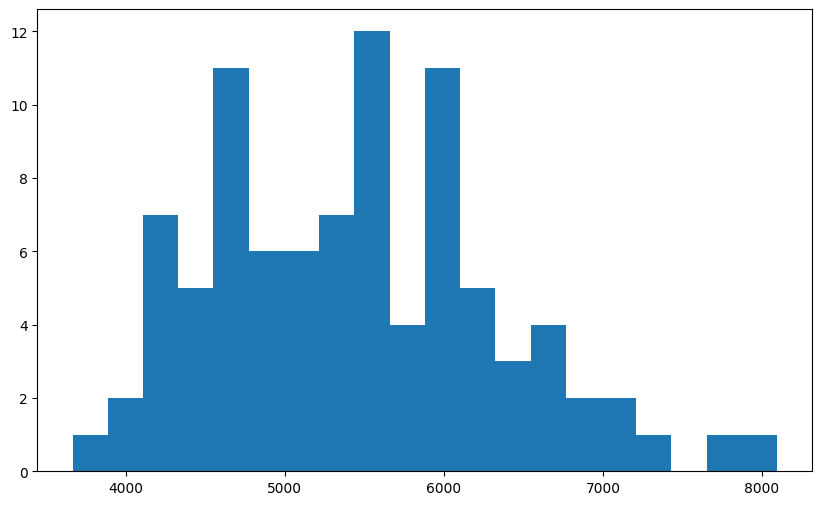

In [265]:
plt.hist(data_df[label], bins=20)
plt.show()

In [266]:
'''
MaxAbsScaler maintains the outliers 
https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py

'''
scaler = MaxAbsScaler()
scaler.fit(data_df[label].to_numpy().reshape(-1, 1))
scaled_label = scaler.transform(data_df[label].to_numpy().reshape(-1, 1)).flatten()
find_outliers_IQR(pd.Series(scaled_label))

34    1.0
dtype: float64

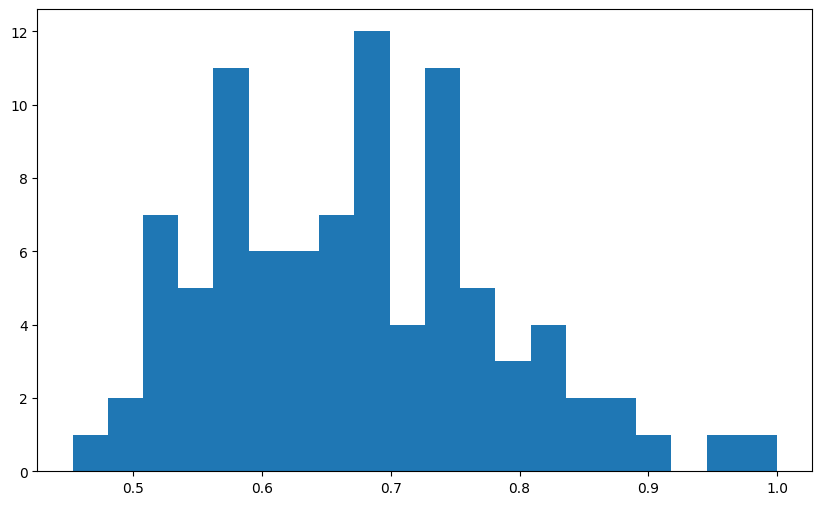

In [245]:
plt.hist(scaled_label, bins=20)
plt.show()

## Drop the outlier

In [127]:
data_df = data_df.drop(data_df[data_df['Date']=='2021-12-26'].index)

In [128]:
data_df[data_df['Date']=='2021-12-26']

Empty DataFrame
Columns: [Date, HSIA_RGU_ACTUAL_VOLUME, BRAND_HSIA_RADIO_IMPRESSIONS, BRAND_HSIA_OOH_IMPRESSIONS, BRAND_HSIA_TV_IMPRESSIONS, PERFORMANCE_HSIA_VID_IMPRESSIONS, PERFORMANCE_HSIA_SOC_IMPRESSIONS, PERFORMANCE_HSIA_DSP_IMPRESSIONS, CONVERSION_HSIA_SEARCH_IMPRESSIONS, CONSIDERATION_HSIA_SEARCH_IMPRESSIONS, BRAND_HSIA_VID_IMPRESSIONS, BRAND_HSIA_SOC_IMPRESSIONS, BRAND_HSIA_DSP_IMPRESSIONS, OPTIK_TOTAL_IMPRESSIONS, TOS_TOTAL_IMPRESSIONS, MASTERBRAND_DIGITAL_IMPRESSIONS, HOLIDAYS, YEARLY_SEASONALITY]
Index: []

In [247]:
#find_outliers_IQR(data_df[label])

Series([], Name: HSIA_RGU_ACTUAL_VOLUME, dtype: int64)

# Define Transformations

Below are the transformation functions for adstock and saturation. 

In [106]:
def delayed_adstock(
    x, alpha: float = 0.0, theta: int = 0, l_max: int = 13, normalize: bool = False
):
    """Delayed adstock transformation.
    This transformation is similar to geometric adstock transformation, but it
    allows for a delayed peak of the effect. The peak is assumed to occur at `theta`.
    Parameters
    ----------
    x : tensor
        Input tensor.
    alpha : float, by default 0.0
        Retention rate of ad effect. Must be between 0 and 1.
    theta : float, by default 0
        Delay of the peak effect. Must be between 0 and `l_max` - 1.
    l_max : int, by default 12
        Maximum duration of carryover effect.
    normalize : bool, by default False
        Whether to normalize the weights.
    Returns
    -------
    tensor
        Transformed tensor.
    References
    ----------
    .. [1] Jin, Yuxue, et al. "Bayesian methods for media mix modeling
       with carryover and shape effects." (2017).
    """
    cycles = [pt.concatenate([pt.zeros(i), x[: x.shape[0] - i]]) for i in range(l_max)]
    x_cycle = pt.stack(cycles)
    w = pt.as_tensor_variable(
        [pt.power(alpha, ((i - theta) ** 2)) for i in range(l_max)]
    )
    w = w / pt.sum(w) if normalize else w
    return pt.dot(w, x_cycle)

def delayed_adstock_vectorized(
    x, alpha, theta, l_max: int = 12, normalize: bool = False
):
    """Delayed adstock transformation."""
    cycles = [
        pt.concatenate(tensor_list=[pt.zeros(shape=x.shape)[:i], x[: x.shape[0] - i]])
        for i in range(l_max)
    ]
    x_cycle = pt.stack(cycles)
    x_cycle = pt.transpose(x=x_cycle, axes=[1, 2, 0])
    w = pt.as_tensor_variable(
        [pt.power(alpha, ((i - theta) ** 2)) for i in range(l_max)]
    )
    w = pt.transpose(w)[None, ...]
    w = w / pt.sum(w, axis=2, keepdims=True) if normalize else w
    return pt.sum(pt.mul(x_cycle, w), axis=2)

def geometric_adstock_vectorized(x, alpha, l_max: int = 12, normalize: bool = False):
    """Vectorized geometric adstock transformation."""
    cycles = [
        pt.concatenate(tensor_list=[pt.zeros(shape=x.shape)[:i], x[: x.shape[0] - i]])
        for i in range(l_max)
    ]
    x_cycle = pt.stack(cycles)
    x_cycle = pt.transpose(x=x_cycle, axes=[1, 2, 0])
    w = pt.as_tensor_variable([pt.power(alpha, i) for i in range(l_max)])
    w = pt.transpose(w)[None, ...]
    w = w / pt.sum(w, axis=2, keepdims=True) if normalize else w
    return pt.sum(pt.mul(x_cycle, w), axis=2)

def saturation(x, K: float = 0.0):
    
    '''
    reach transform = 1 - (K/(x+K))
    K: Half Saturation Point 
    Slope is fixed to 1
    
    Reference: https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/46001.pdf
    
    '''
    
    return (1 - (K/(x+K)))

def logistic_saturation(x, lam: float = 0.5):
    """Logistic saturation transformation.
    Parameters
    ----------
    x : tensor
        Input tensor.
    lam : float, optional, by default 0.5
        Saturation parameter.
    Returns
    -------
    tensor
        Transformed tensor.
    """
    return (1 - pt.exp(-lam * x)) / (1 + pt.exp(-lam * x))

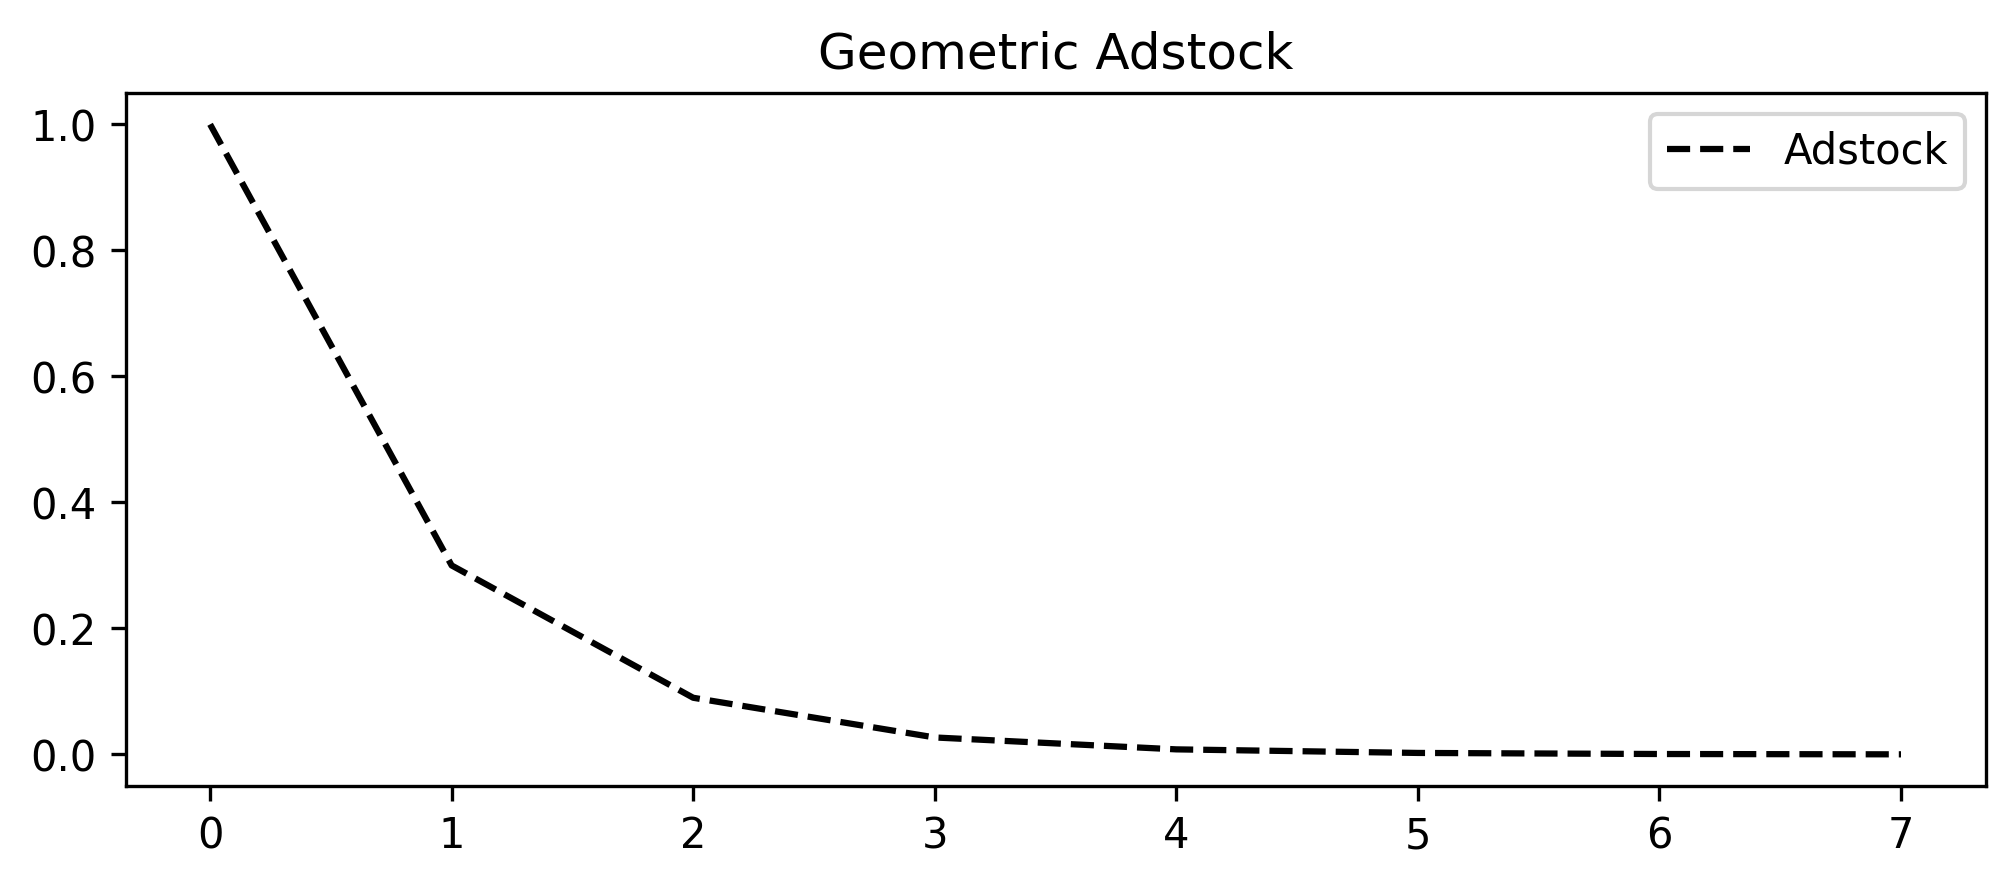

In [107]:
alpha = 0.3
l_max = 8

w = pt.as_tensor_variable([pt.power(alpha, i) for i in range(l_max)])

fig = plt.figure(figsize=(8,3),dpi=300)
plt.plot([i for i in range(l_max)],w.eval().flatten(),'k--',label='Adstock')
plt.legend()
plt.title('Geometric Adstock')
plt.show()

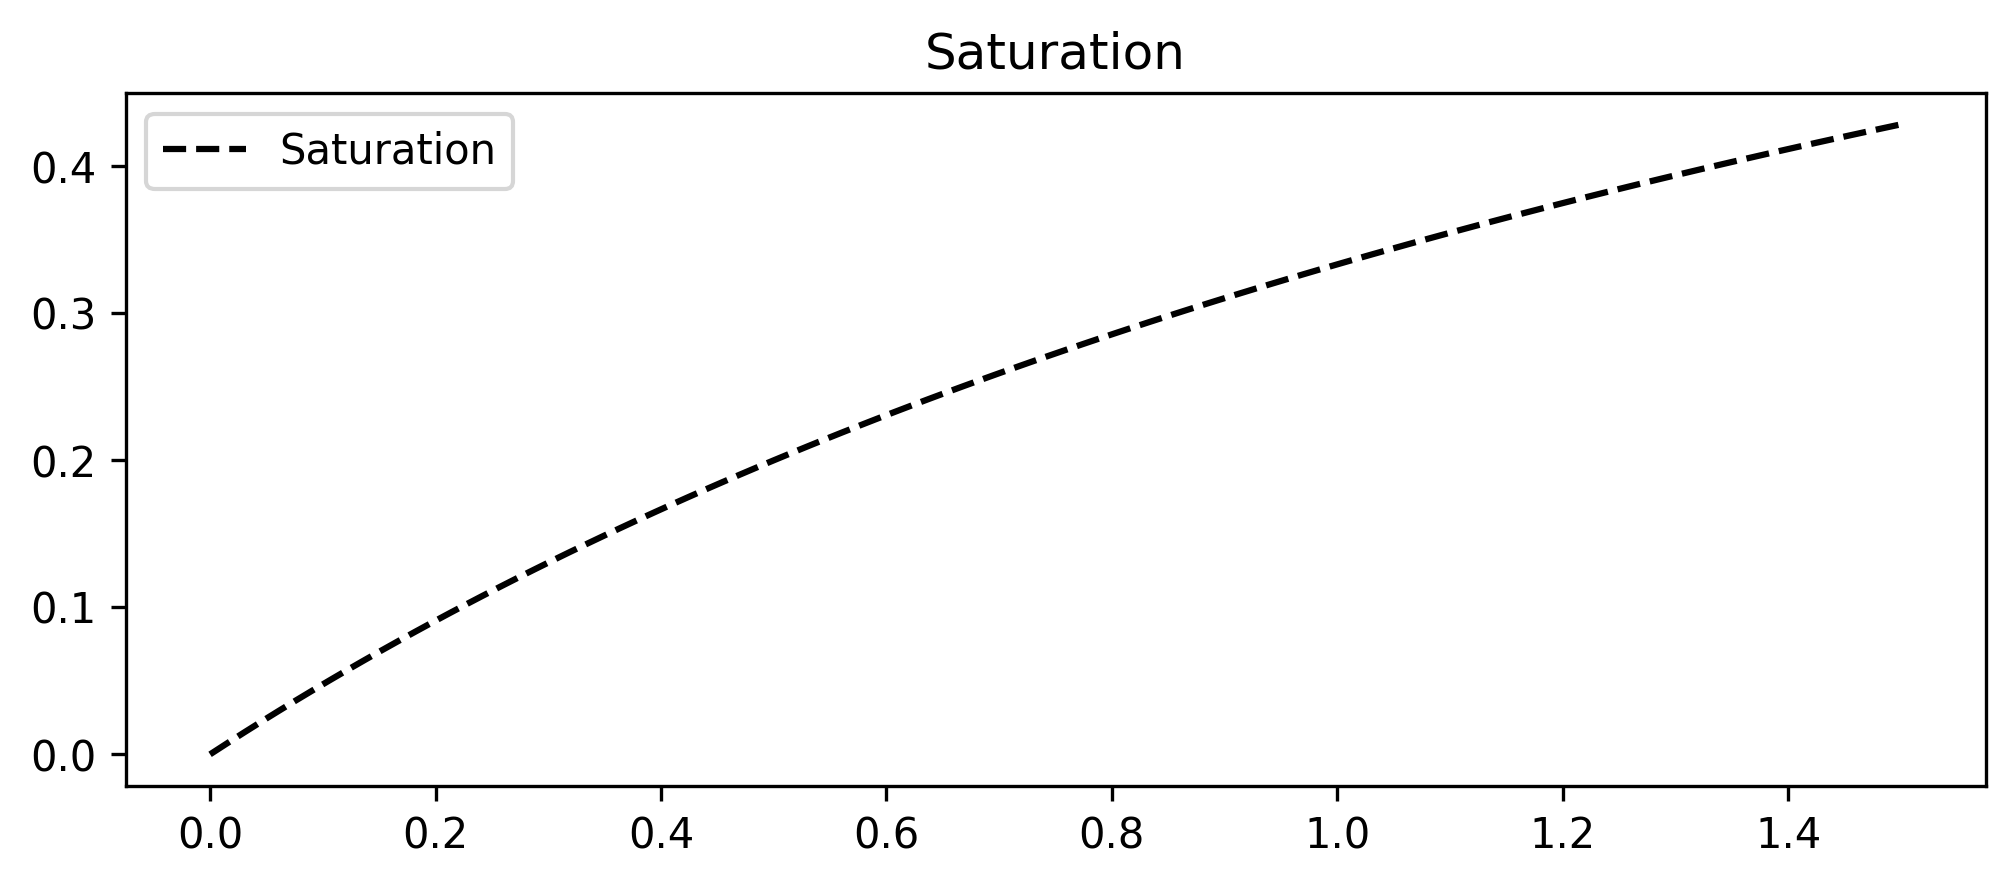

In [108]:
x=np.linspace(0,1.5,100)
beta = 1 


fig = plt.figure(figsize=(8,3),dpi=300)
plt.plot(x,beta* saturation(x,2),'k--',label='Saturation')
plt.legend()
plt.title('Saturation')
plt.show()

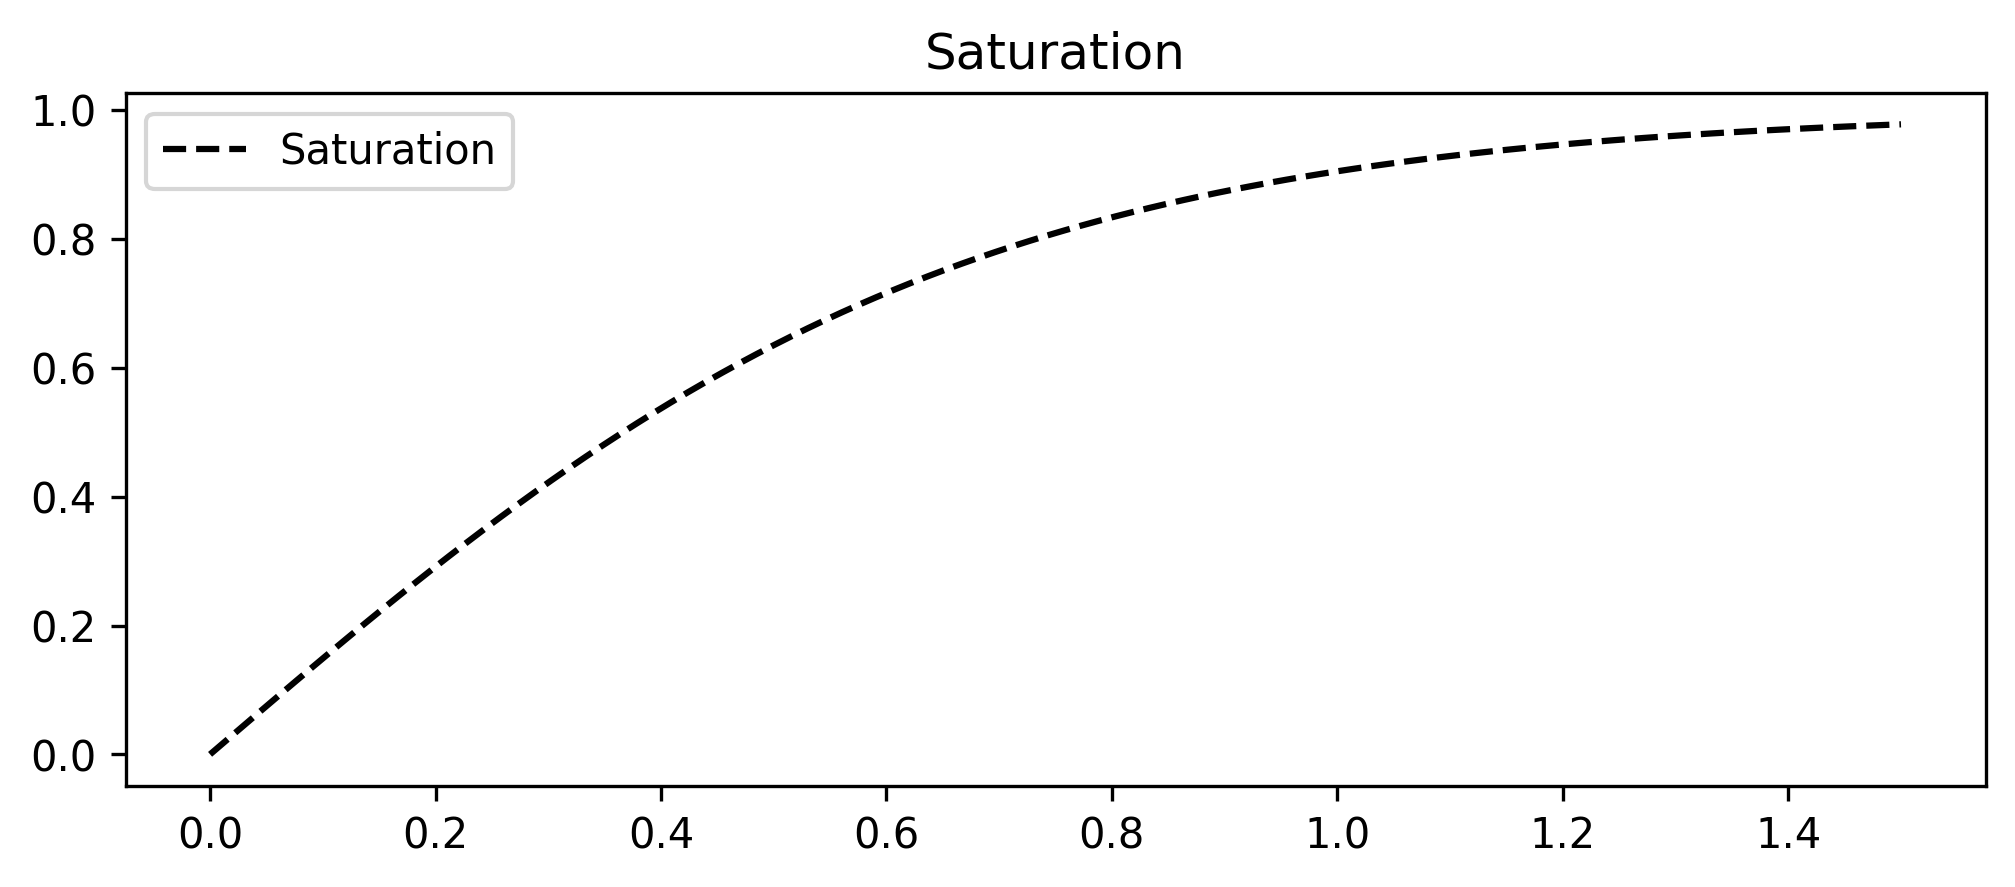

In [109]:
x=np.linspace(0,1.5,100)
beta = 1 


fig = plt.figure(figsize=(8,3),dpi=300)
plt.plot(x, logistic_saturation(x,3).eval().flatten(),'k--',label='Saturation')
plt.legend()
plt.title('Saturation')
plt.show()

# Define Evaluation Functions

In [110]:
def nrmse(y_actual, y_pred):
    # normalized root mean square error
    value = round(np.sqrt(metrics.mean_squared_error(y_actual, y_pred)) / np.mean(y_actual), 3)
    return value

In [111]:
def rsquared(y_actual, y_pred, n, k):
    # r squared
    value = round(metrics.r2_score(y_actual, y_pred), 3)
    return 1-((1-value))*((n-1)/(n-k-1))

# Scale the Data

Here we scale the data and keep individual scalers for each variable in a dataframe called scaler_df so that we can use them later to transform out-of-sample data. 

In [162]:
#Scale the data 
scaler_list = []
scaled_data = []

columns_to_keep = [label] + media + control


for col in columns_to_keep:
    scaler = MaxAbsScaler()
    scaler.fit(data_df[col].to_numpy().reshape(-1, 1))
    scaled = pd.Series(scaler.transform(data_df[col].to_numpy().reshape(-1, 1)).flatten())
    scaled.name = col
    scaled_data.append(scaled)
    scaler_list.append({'MaxAbsScaler':scaler})

scaler_df = pd.DataFrame(scaler_list,index=columns_to_keep)
scaler_df

MaxAbsScaler
HSIA_RGU_ACTUAL_VOLUME                 MaxAbsScaler()
BRAND_HSIA_RADIO_IMPRESSIONS           MaxAbsScaler()
BRAND_HSIA_OOH_IMPRESSIONS             MaxAbsScaler()
BRAND_HSIA_TV_IMPRESSIONS              MaxAbsScaler()
PERFORMANCE_HSIA_VID_IMPRESSIONS       MaxAbsScaler()
PERFORMANCE_HSIA_SOC_IMPRESSIONS       MaxAbsScaler()
PERFORMANCE_HSIA_DSP_IMPRESSIONS       MaxAbsScaler()
CONVERSION_HSIA_SEARCH_IMPRESSIONS     MaxAbsScaler()
CONSIDERATION_HSIA_SEARCH_IMPRESSIONS  MaxAbsScaler()
BRAND_HSIA_VID_IMPRESSIONS             MaxAbsScaler()
BRAND_HSIA_SOC_IMPRESSIONS             MaxAbsScaler()
BRAND_HSIA_DSP_IMPRESSIONS             MaxAbsScaler()
OPTIK_TOTAL_IMPRESSIONS                MaxAbsScaler()
TOS_TOTAL_IMPRESSIONS                  MaxAbsScaler()
MASTERBRAND_DIGITAL_IMPRESSIONS        MaxAbsScaler()
HOLIDAYS                               MaxAbsScaler()
YEARLY_SEASONALITY                     MaxAbsScaler()

In [163]:
scaled_data_df = pd.concat(scaled_data, axis=1)
scaled_data_df.insert(0, 'Date', data_df.Date)
#scaled_data_df.index = data_df.Date
scaled_data_df.head()

Date  HSIA_RGU_ACTUAL_VOLUME  BRAND_HSIA_RADIO_IMPRESSIONS  \
0 2021-01-03                0.652996                      0.275312   
1 2021-01-10                0.558863                      0.275312   
2 2021-01-17                0.521062                      0.275312   
3 2021-01-24                0.516739                      0.275312   
4 2021-01-31                0.696109                      0.000000   

   BRAND_HSIA_OOH_IMPRESSIONS  BRAND_HSIA_TV_IMPRESSIONS  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         0.0                        0.0   
4                         0.0                        0.0   

   PERFORMANCE_HSIA_VID_IMPRESSIONS  PERFORMANCE_HSIA_SOC_IMPRESSIONS  \
0                               0.0                          0.101342   
1                               0.0                          0.023946   
2                               0.0                          0.025510   
3                               0.0                          0.022150   
4                               0.0                          0.053638   

   PERFORMANCE_HSIA_DSP_IMPRESSIONS  CONVERSION_HSIA_SEARCH_IMPRESSIONS  \
0                          0.052756                            0.150282   
1                          0.075885                            0.197088   
2                          0.070480                            0.257775   
3                          0.055314                            0.268449   
4                          0.052051                            0.209311   

   CONSIDERATION_HSIA_SEARCH_IMPRESSIONS  BRAND_HSIA_VID_IMPRESSIONS  \
0                               0.352018                    0.000000   
1                               0.295963                    0.003126   
2                               0.475350                    0.008040   
3                               0.592827                    0.008023   
4                               0.658788                    0.009359   

   BRAND_HSIA_SOC_IMPRESSIONS  BRAND_HSIA_DSP_IMPRESSIONS  \
0                    0.032473                    0.032172   
1                    0.071958                    0.089325   
2                    0.163564                    0.081095   
3                    0.153098                    0.056237   
4                    0.219043                    0.082407   

   OPTIK_TOTAL_IMPRESSIONS  TOS_TOTAL_IMPRESSIONS  \
0                 0.080024               0.230268   
1                 0.027389               0.234806   
2                 0.046036               0.284955   
3                 0.113957               0.314771   
4                 0.129014               0.312381   

   MASTERBRAND_DIGITAL_IMPRESSIONS  HOLIDAYS  YEARLY_SEASONALITY  
0                         0.409812 -0.064939            0.259755  
1                         0.059989  0.000000           -0.263167  
2                         0.062025  0.000000           -0.547974  
3                         0.090913  0.000000            0.202587  
4                         0.110266  0.000000            0.781366

In [164]:
len(scaled_data_df)

91

In [165]:
scaled_data_df[control+[label]].describe()

HOLIDAYS  YEARLY_SEASONALITY  HSIA_RGU_ACTUAL_VOLUME
count  91.000000           91.000000               91.000000
mean   -0.014870           -0.004732                0.671728
std     0.120985            0.492228                0.111837
min    -1.000000           -0.638345                0.452872
25%     0.000000           -0.365806                0.585238
50%     0.000000           -0.232258                0.672637
75%     0.000000            0.353294                0.744966
max     0.137270            1.000000                1.000000

# Inverse Transform

Just checking that inverse transform gives us the original unscaled data.

In [115]:
scaler_df.loc[label].values[0].inverse_transform([scaled_data_df[label]])

array([[5286., 4524., 4218., 4183., 5635., 4109., 4123., 4520., 5324.,
        4060., 4129., 4011., 4705., 4898., 4643., 4375., 5445., 6089.,
        5195., 4834., 4765., 6222., 5465., 4814., 4881., 5458., 6025.,
        4862., 4744., 5075., 6350., 5596., 5881., 6025., 8095., 6871.,
        6221., 5462., 6580., 6622., 5014., 5289., 5405., 6701., 5101.,
        5319., 5529., 7365., 6334., 5953., 4985., 3666., 5196., 5235.,
        4716., 4594., 5786., 4590., 4644., 4291., 5665., 4644., 4731.,
        4299., 5530., 5961., 4351., 4395., 5040., 6890., 6058., 5228.,
        4758., 6721., 6115., 5447., 5452., 5986., 7076., 6025., 5465.,
        5735., 6440., 6299., 6036., 5771., 7845., 7093., 6052., 5580.,
        6104.]])

# Specify Model

Below we first specify the data for the model and then specify the model. 

In [132]:
#Specify data

date_data = scaled_data_df['Date']
target_data = scaled_data_df[label]
channel_data = scaled_data_df[media]
control_data = scaled_data_df[control]

In [117]:
#https://github.com/slavakx/bayesian_mmm/blob/main/robyn_methodology_bayesian_pymc3_article.ipynb
#https://github.com/pymc-labs/pymc-marketing/blob/main/pymc_marketing/mmm/delayed_saturated_mmm.py

with pm.Model() as model:
    
    #add_coord specifies the dimensions the model is working with 
    model.add_coord('date',date_data,mutable='True')
    model.add_coord('channel',channel_data.columns)
    model.add_coord('control',control_data.columns)
    
    #Data container for channel data
    channel_data_ = pm.MutableData(
                name="channel_data",
                value=channel_data,
                dims=("date", "channel"),
            )
    
    #Data container for the label
    target_ = pm.MutableData(name="target", value=target_data, dims="date")

    #Distribution for the intercept 
    intercept = pm.Gamma(name="intercept", alpha=7.5, beta=1)
    
    #Distribution for the coefficients/beta for the channels
    beta_channel = pm.HalfNormal(
                name="beta_channel", sigma=2, dims="channel"
            )
    
    #Distribution for alpha parameter for adstock
    alpha = pm.Beta(name="alpha", alpha=1, beta=3, dims="channel")

    
    #Distribution for lambda parameter in saturation
    lam = pm.Gamma(name="lam", alpha=3, beta=1, dims="channel")

    #Distribution of noise 
    sigma = pm.HalfNormal(name="sigma", sigma=4)
    
    #Calculate the channel adstock 
    channel_adstock = pm.Deterministic(
                name="channel_adstock",
                var=geometric_adstock_vectorized(
                    x=channel_data_,
                    alpha=alpha,
                    l_max=8
                ),
                dims=("date", "channel"),
            )
    #Calculate the channel saturation
    channel_adstock_saturated = pm.Deterministic(
                name="channel_adstock_saturated",
                var=logistic_saturation(x=channel_adstock, lam=lam),
                dims=("date", "channel"),
            )
    #Calculate the channel contributions
    channel_contributions = pm.Deterministic(
                name="channel_contributions",
                var=channel_adstock_saturated * beta_channel,
                dims=("date", "channel"),
            )

    mu_var = intercept + channel_contributions.sum(axis=-1)

    if control_data is not None:
        #Data container for control data
        control_data_ = pm.MutableData(
                    name="control_data", value=control_data, dims=("date", "control")
                )

        #Coefficients for control data
        gamma_control = pm.Normal(
                    name="gamma_control", mu=0, sigma=2, dims="control"
                )

        #Calculate control contributions 
        control_contributions = pm.Deterministic(
                    name="control_contributions",
                    var=control_data_ * gamma_control,
                    dims=("date", "control"),
                )

        mu_var += control_contributions.sum(axis=-1)

    mu = pm.Deterministic(name="mu", var=mu_var, dims="date")

    #Define the likelihood function 
    pm.Normal(
                name="outcome",
                mu=mu,
                sigma=sigma,
                observed=target_,
                dims="date",
            )

In [118]:
#Render the model as graphic and save to pdf
pm.model_to_graphviz(model=model).render('pymc3_hsia_graph_v8.2_final')

'pymc3_hsia_graph_v8.2_final.pdf'

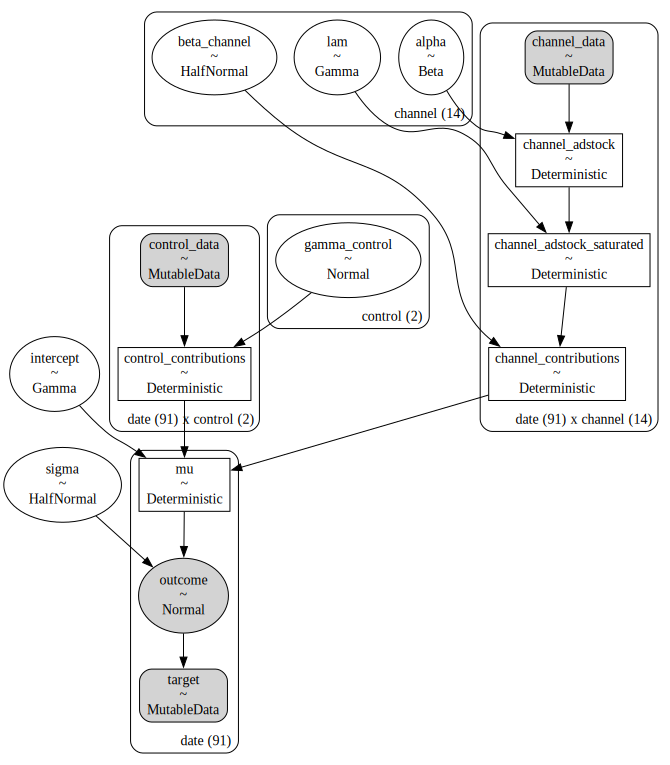

In [119]:
pm.model_to_graphviz(model=model)

# Prior Checks

We can use this section to check the prior distributions for our variables. I have demonstrated for the intercept.

In [37]:
with model:
    prior_checks = pm.sample_prior_predictive(samples=1000, random_seed=42)

Sampling: [alpha, beta_channel, gamma_control, intercept, lam, outcome, sigma, theta]


array([[<AxesSubplot:title={'center':'intercept'}>]], dtype=object)

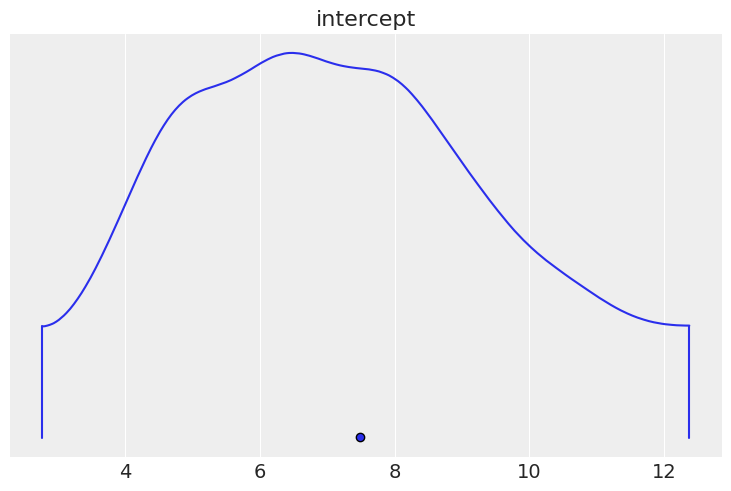

In [38]:
az.plot_density(prior_checks.prior["intercept"])

# Fit Model

We can increase the number of steps taken by the algorithm. Additionally, the 'step' parameter can be set drop every 2nd or 3rd sample to reduce autocorrelation within the chain. 

In [133]:
with model:
    trace = pm.sample(5000, tune=1000, step=None, target_accept = 0.99, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta_channel, alpha, lam, sigma, gamma_control]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 1464 seconds.


# Saving Trace to Reload in Future

Saving the trace to save time in case we want to work with the same model in the future but don't want to retrain.

In [225]:
#https://discourse.pymc.io/t/how-to-save-my-trace-in-the-system/7222/7
trace.to_netcdf("hsia_model_v8.2_final.nc")

'hsia_model_v8.2_final.nc'

In [65]:
trace = az.from_netcdf("hsia_model_v8.2_final.nc")

# Model Stats

In [134]:
with model:
    pm.compute_log_likelihood(trace)

How to interpret p_loo metric: ([See More](https://avehtari.github.io/modelselection/CV-FAQ.html#17_What_to_do_if_I_have_many_high_Pareto))

- The Pareto-k̂ diagnostic estimates how far an individual leave-one-out distribution is from the full distribution. If leaving out an observation changes the posterior too much then importance sampling is not able to give reliable estimate. 
    - If k̂ <0.5, then the corresponding component of elpd_loo is estimated with high accuracy. 
    - If 0.5<k̂ <0.7 the accuracy is lower, but still OK. 
    - If k̂ >0.7, then importance sampling is not able to provide useful estimate for that component/observation. 
- Pareto-k̂ is also useful as a measure of influence of an observation. Highly influential observations have high k̂ values. Very high k̂ values often indicate model misspecification, outliers or mistakes in data processing. 

In [135]:
model_loo = az.loo(trace, pointwise=True)
model_loo

Computed from 20000 posterior samples and 91 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   144.33     7.58
p_loo       13.29        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       85   93.4%
 (0.5, 0.7]   (ok)          6    6.6%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [136]:
model_loo.pareto_k[model_loo.pareto_k>0.7]

<xarray.DataArray 'pareto_shape' (date: 0)>
array([], dtype=float64)
Coordinates:
  * date     (date) datetime64[ns]

# Convergence Diagnostics

### Gelman-Rubin Statstic 

A quantitative way to check for convergence is by using the Gelman-Rubin test. The idea of this test is to compare the variance between chains with the variance within chains. If convergence has been achieved, the between-chain and within-chain variances should be identical. 

Ideally, we should expect a value of Rˆ =1. As an empirical rule, we will be ok with a value below 1.1; higher values are signaling a lack of convergence.

In [137]:
S = az.convert_to_dataset(trace)

In [138]:
gm_stat = az.rhat(S,var_names= ['beta_channel','gamma_control','intercept','alpha','lam','sigma'])
gm_stat

<xarray.Dataset>
Dimensions:        (channel: 14, control: 2)
Coordinates:
  * control        (control) <U18 'HOLIDAYS' 'YEARLY_SEASONALITY'
  * channel        (channel) <U37 'BRAND_HSIA_RADIO_IMPRESSIONS' ... 'MASTERB...
Data variables:
    beta_channel   (channel) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    gamma_control  (control) float64 1.0 1.0
    intercept      float64 1.0
    alpha          (channel) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    lam            (channel) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    sigma          float64 1.0

In [139]:
gm_stat['beta_channel']

<xarray.DataArray 'beta_channel' (channel: 14)>
array([1.00014833, 1.00008492, 1.00041548, 1.00015521, 1.00023546,
       1.0002629 , 1.0001826 , 1.00036119, 1.00031712, 1.00033993,
       1.00013456, 1.00011252, 1.0003251 , 1.00029895])
Coordinates:
  * channel  (channel) <U37 'BRAND_HSIA_RADIO_IMPRESSIONS' ... 'MASTERBRAND_D...

### Autocorrelation

An ideal sample will lack autocorrelation, that is, a value at one point should be independent of the values at other points. Ideally we should see no autocorrelation, in practice; we seek samples that quickly drop to low values of autocorrelation.

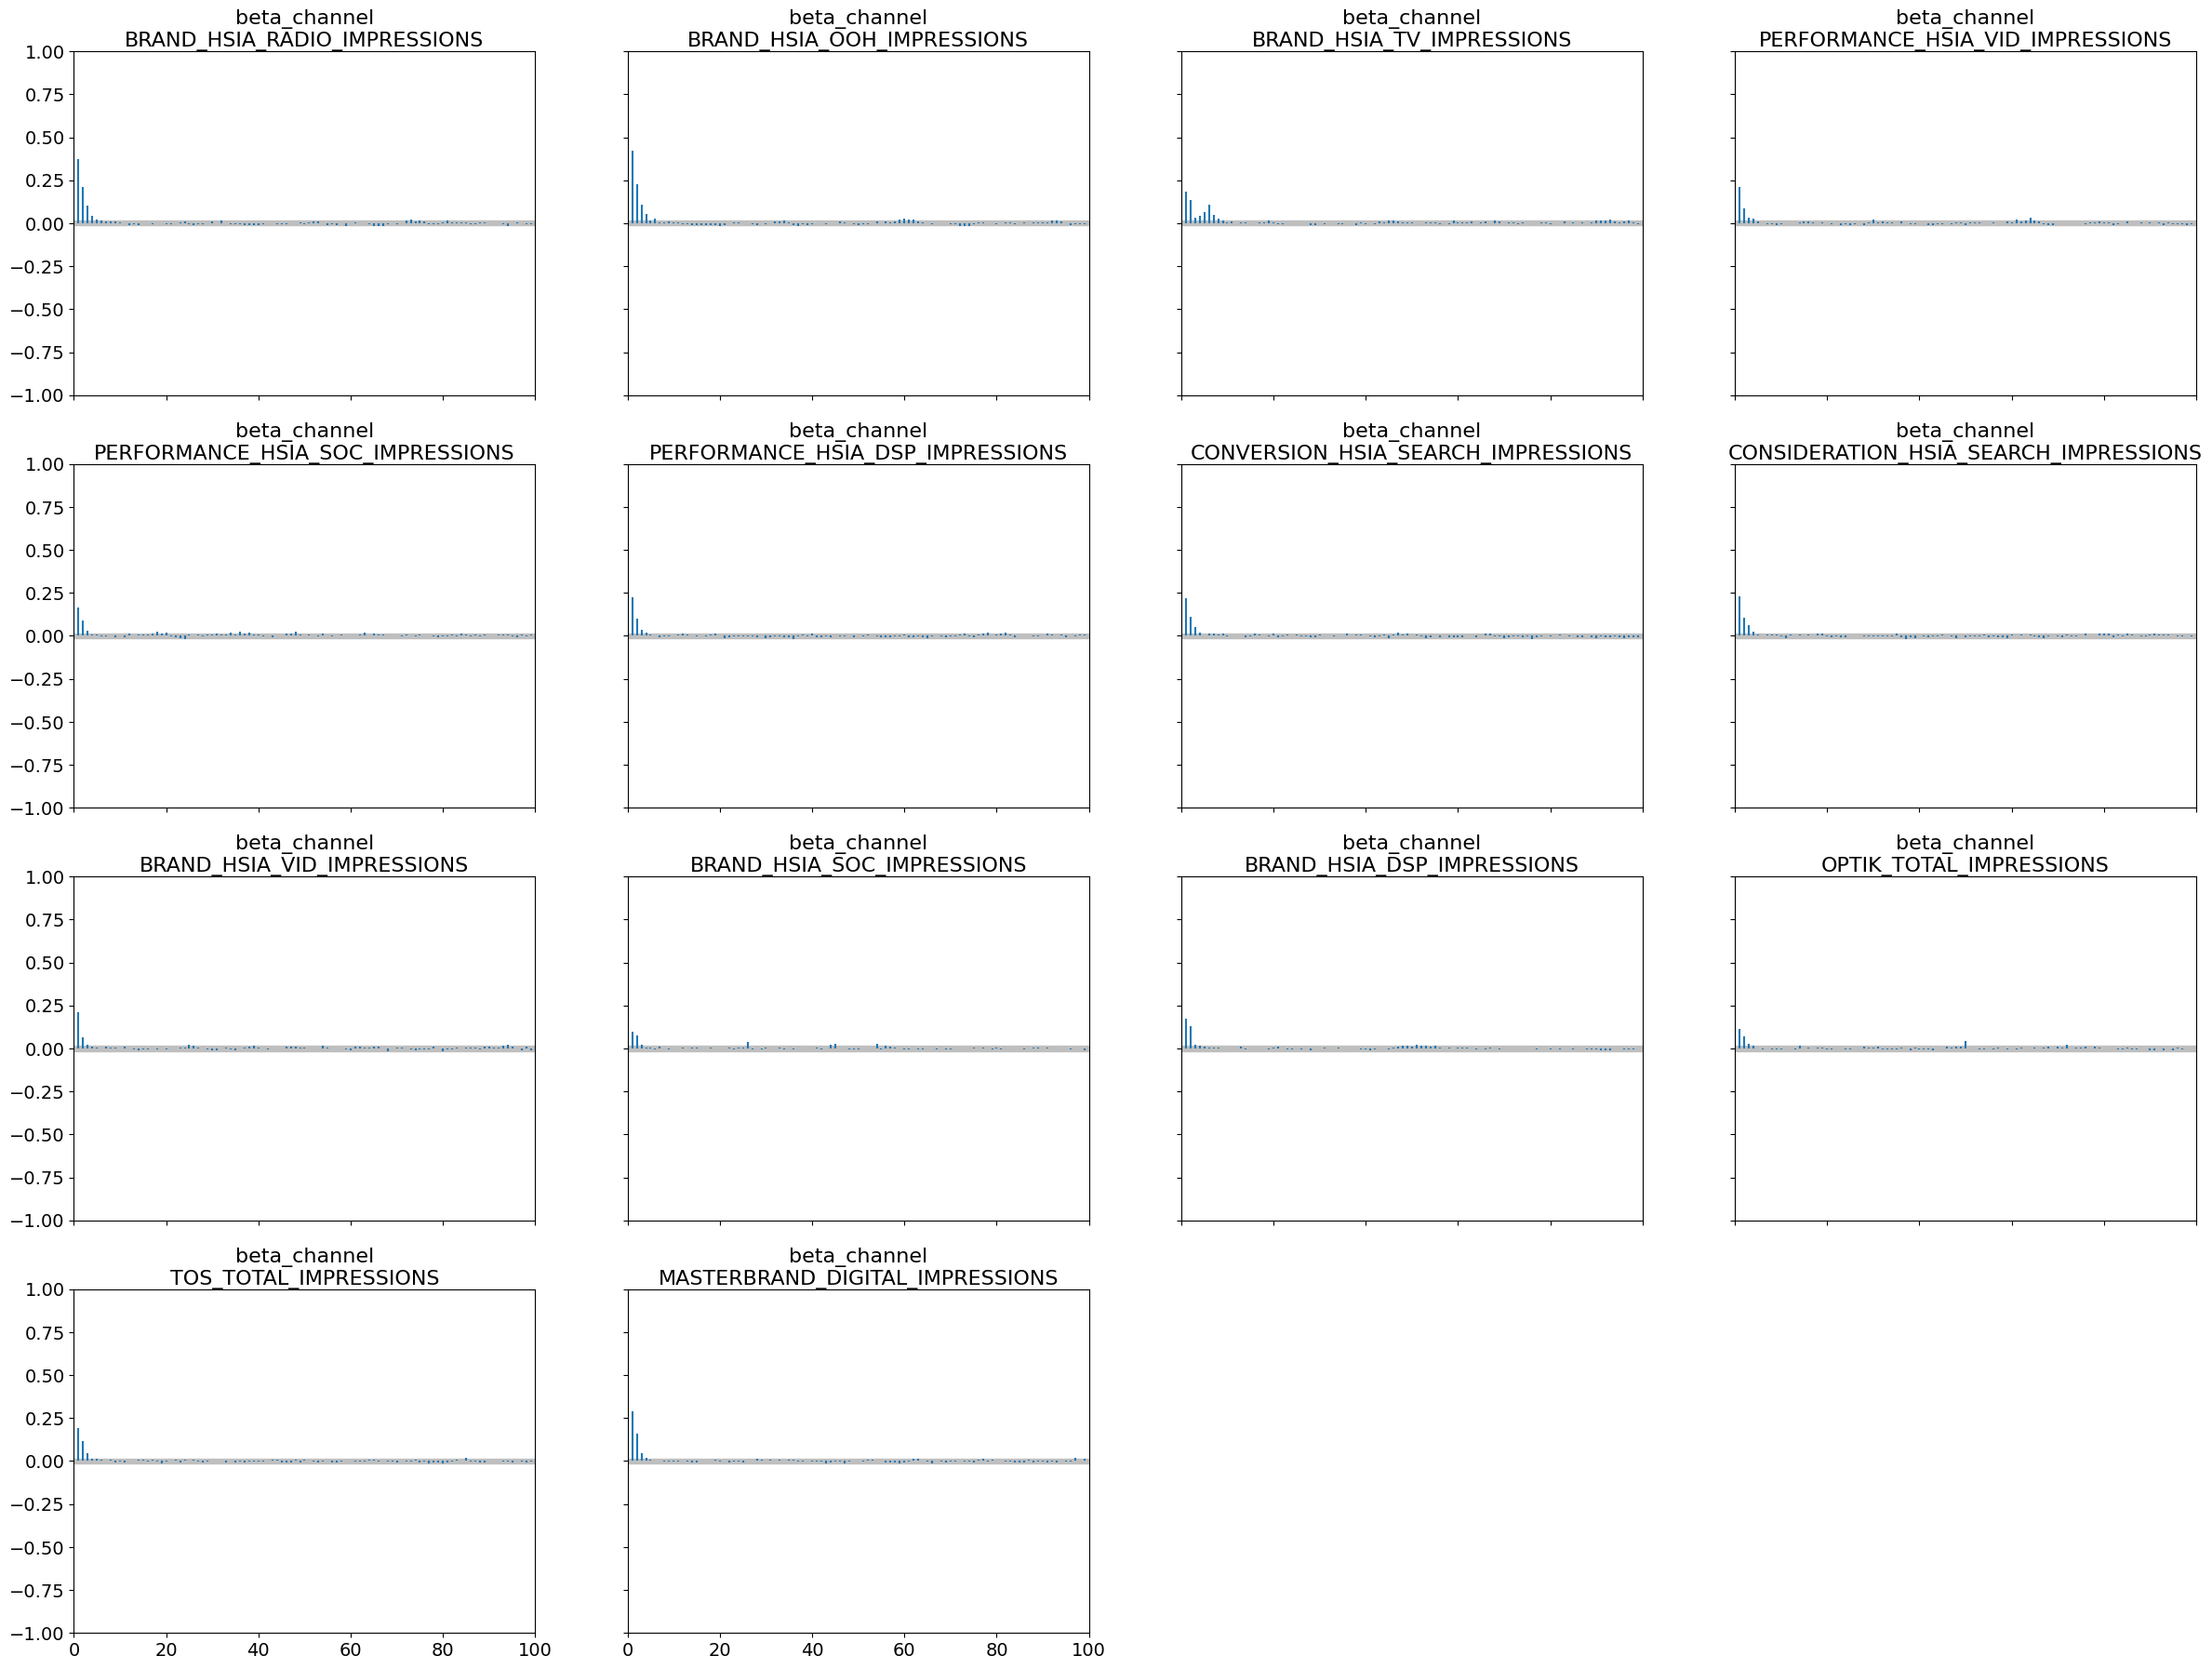

In [140]:
az.plot_autocorr(S, var_names = ['beta_channel'],combined=True)
plt.show()

### Effective Size

A sample with autocorrelation has less information than a sample of the same size without autocorrelation. Hence, given a sample of a certain size with a certain degree of autocorrelation we could try to estimate what will be the size of the sample with the same information without autocorrelation. That number will be the effective size of the sample. Ideally both quantities should be the same; the closer the two numbers the more efficient our sampling.

In [141]:
model_ess = az.ess(S,var_names=['beta_channel','gamma_control','intercept','alpha','lam','sigma'])
model_ess['beta_channel']

<xarray.DataArray 'beta_channel' (channel: 14)>
array([11099.56654783, 10392.67968325, 10118.14025501, 11032.30571202,
       12495.62572746, 11322.60809477, 10783.38382161, 11819.79643315,
       10422.81448462, 13695.65196491, 13154.86801102, 14455.89219697,
       14663.7595157 , 11550.31947522])
Coordinates:
  * channel  (channel) <U37 'BRAND_HSIA_RADIO_IMPRESSIONS' ... 'MASTERBRAND_D...

In [142]:
model_ess['gamma_control']

<xarray.DataArray 'gamma_control' (control: 2)>
array([18102.01430192, 25519.51209741])
Coordinates:
  * control  (control) <U18 'HOLIDAYS' 'YEARLY_SEASONALITY'

# Inspecting Trace

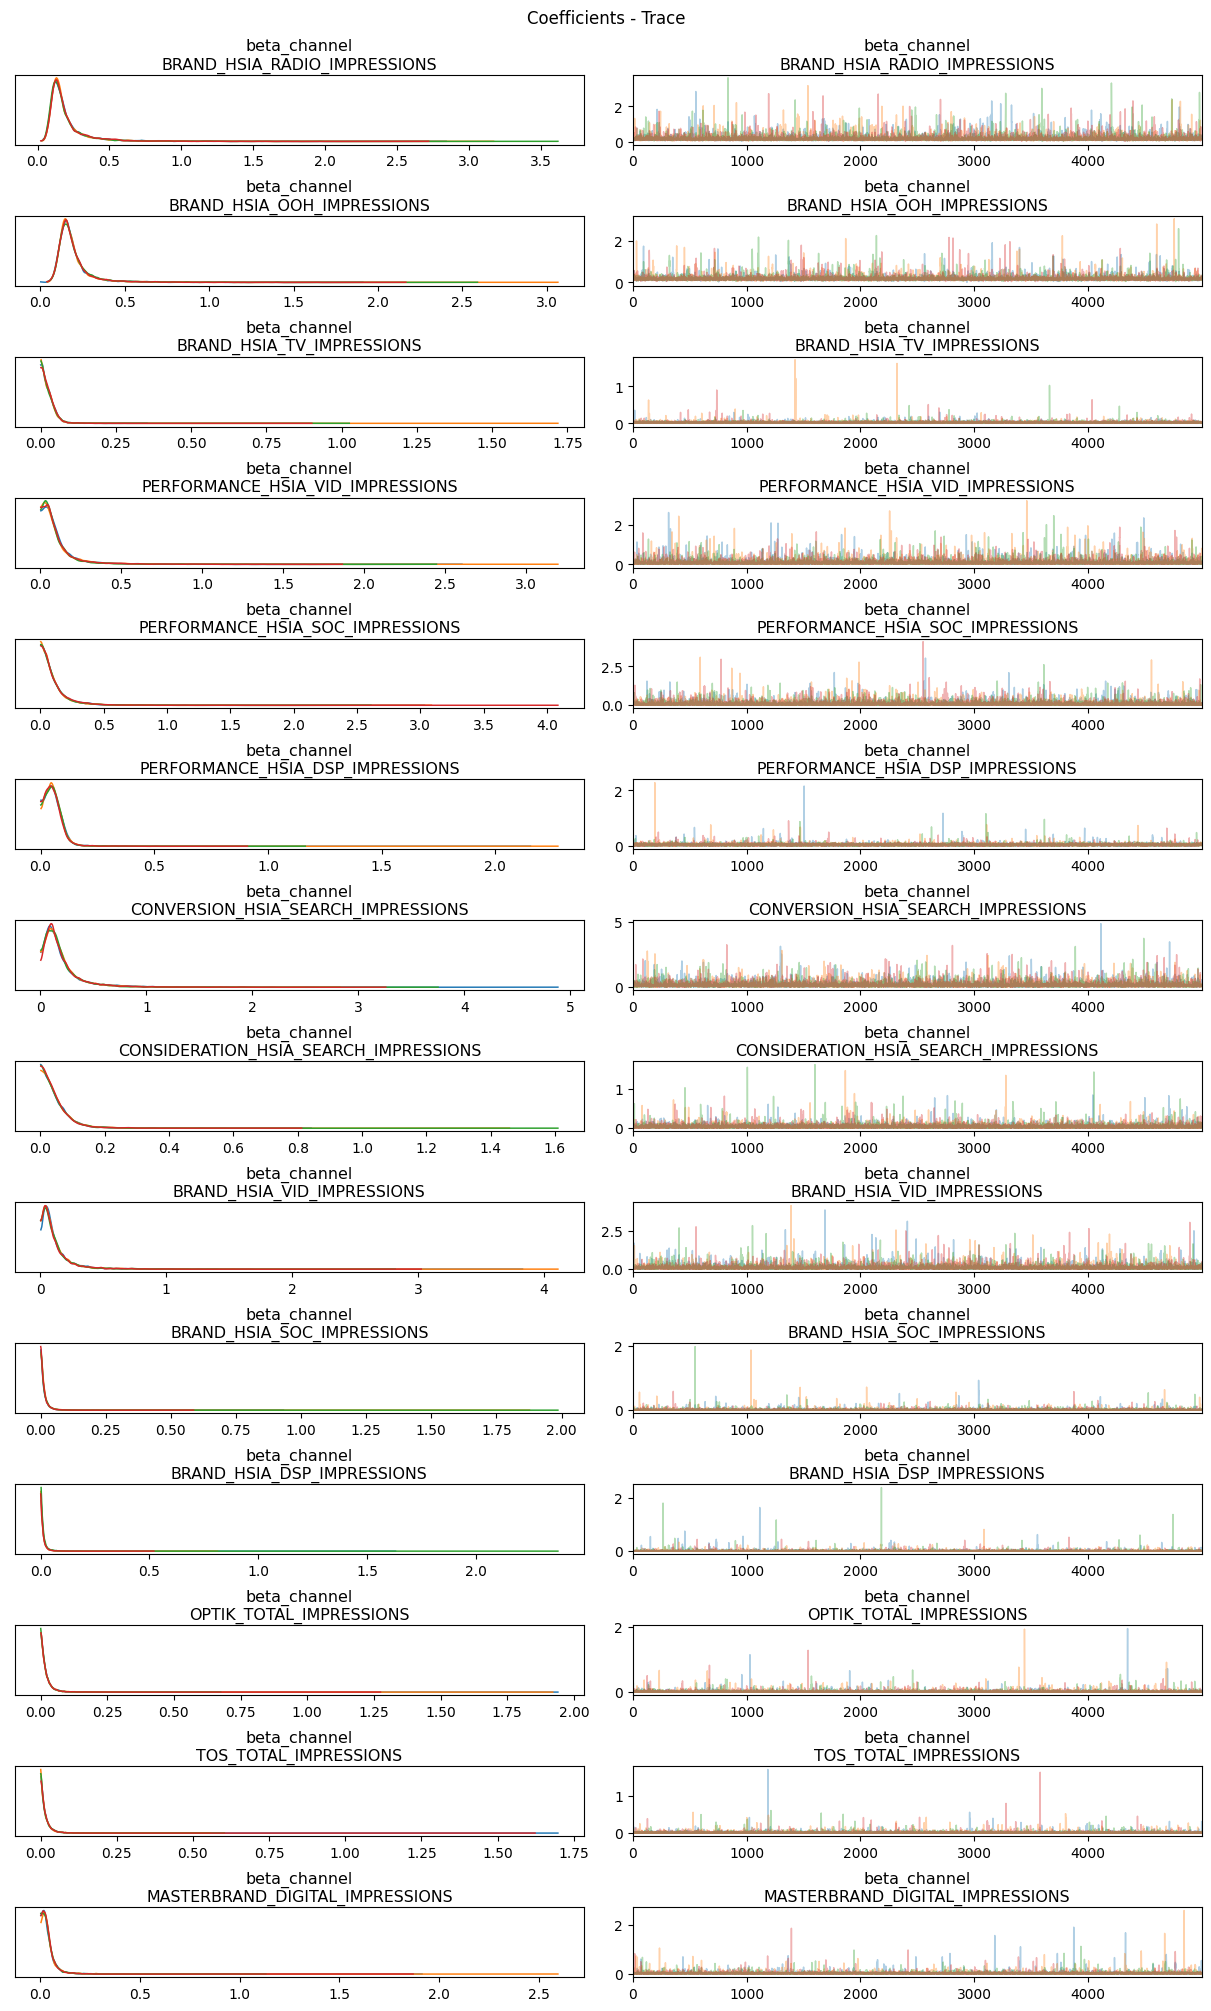

In [143]:
axes = az.plot_trace(
    data=trace,
    var_names=["beta_channel"], #Can also plot any other distributions like ["gamma_control", "alpha", "theta"], etc. 
    compact=False,
    backend_kwargs={
        "figsize": (12, 20),
        "layout": "constrained"
    },
)
fig = axes[0][0].get_figure()
fig.suptitle("Coefficients - Trace");

# Posterior Predictive Check

This checks if the model we have created matches the observed data.

In [144]:
with model:
    ppc_all = pm.sample_posterior_predictive(
        trace, random_seed=42
    )

Sampling: [outcome]


<AxesSubplot:xlabel='outcome / outcome'>

C:\Users\nupur.gokhale\Anaconda3\envs\pm3env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


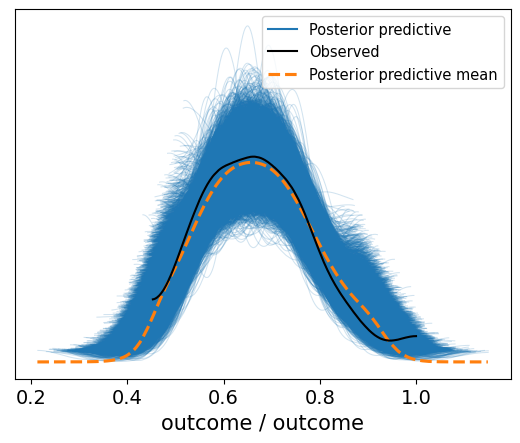

In [145]:
az.plot_ppc(ppc_all, data_pairs = {'HSIA_RGU_ACTUAL_VOLUME':'outcome'})

In [146]:
palette = "cool"
cmap = plt.get_cmap(palette)
percs = np.linspace(51, 99, 100)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))

In [148]:
len(posterior_predictive_y_inv.mean(axis=1))

91

NRMSE of training data: 0.062


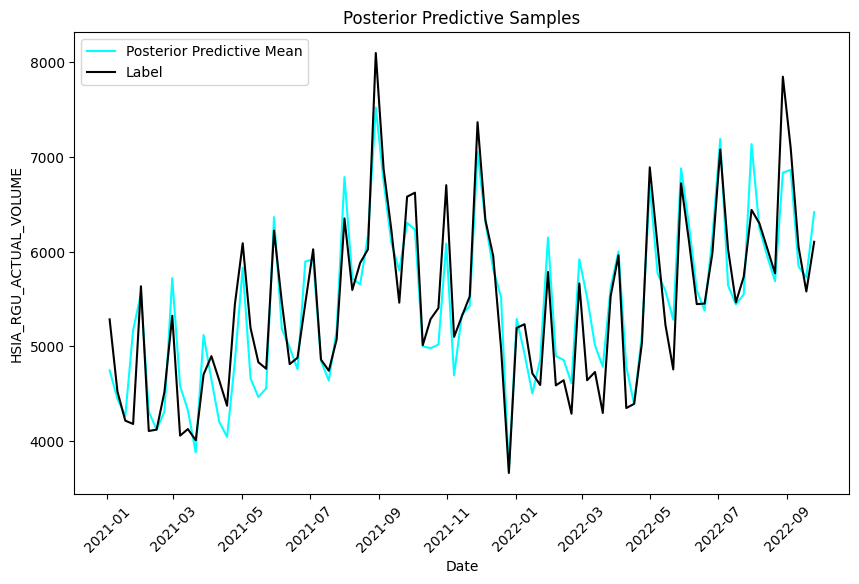

In [166]:
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100

var = 'HSIA_RGU_ACTUAL_VOLUME'

posterior_predictive_y = az.extract(
    data=ppc_all,
    group="posterior_predictive",
    var_names="outcome",
)


posterior_predictive_y_inv = scaler_df.loc[var].values[0].inverse_transform(
    X=posterior_predictive_y
)

print(f"NRMSE of training data: {nrmse(posterior_predictive_y_inv.mean(axis=1),data_df[var])}")

fig, ax = plt.subplots()

'''for i, p in enumerate(percs[::-1]):
    upper = np.percentile(posterior_predictive_y_inv, p, axis=1)
    lower = np.percentile(posterior_predictive_y_inv, 100 - p, axis=1)
    color_val = colors[i]
    ax.fill_between(
        x=data_df['Date'],
        y1=upper,
        y2=lower,
        color=cmap(color_val),
        alpha=0.1,
    )'''

sns.lineplot(
    x=data_df['Date'],
    y=posterior_predictive_y_inv.mean(axis=1),
    color="cyan",
    label="Posterior Predictive Mean",
    ax=ax,
)
sns.lineplot(
    x=data_df['Date'],
    y=data_df[var],
    color="black",
    label="Label",
    ax=ax,
)
ax.legend(loc="upper left")
plt.xticks(rotation=45)
plt.savefig('train_fit.png')
ax.set(title="Posterior Predictive Samples");

# Summarizing Results

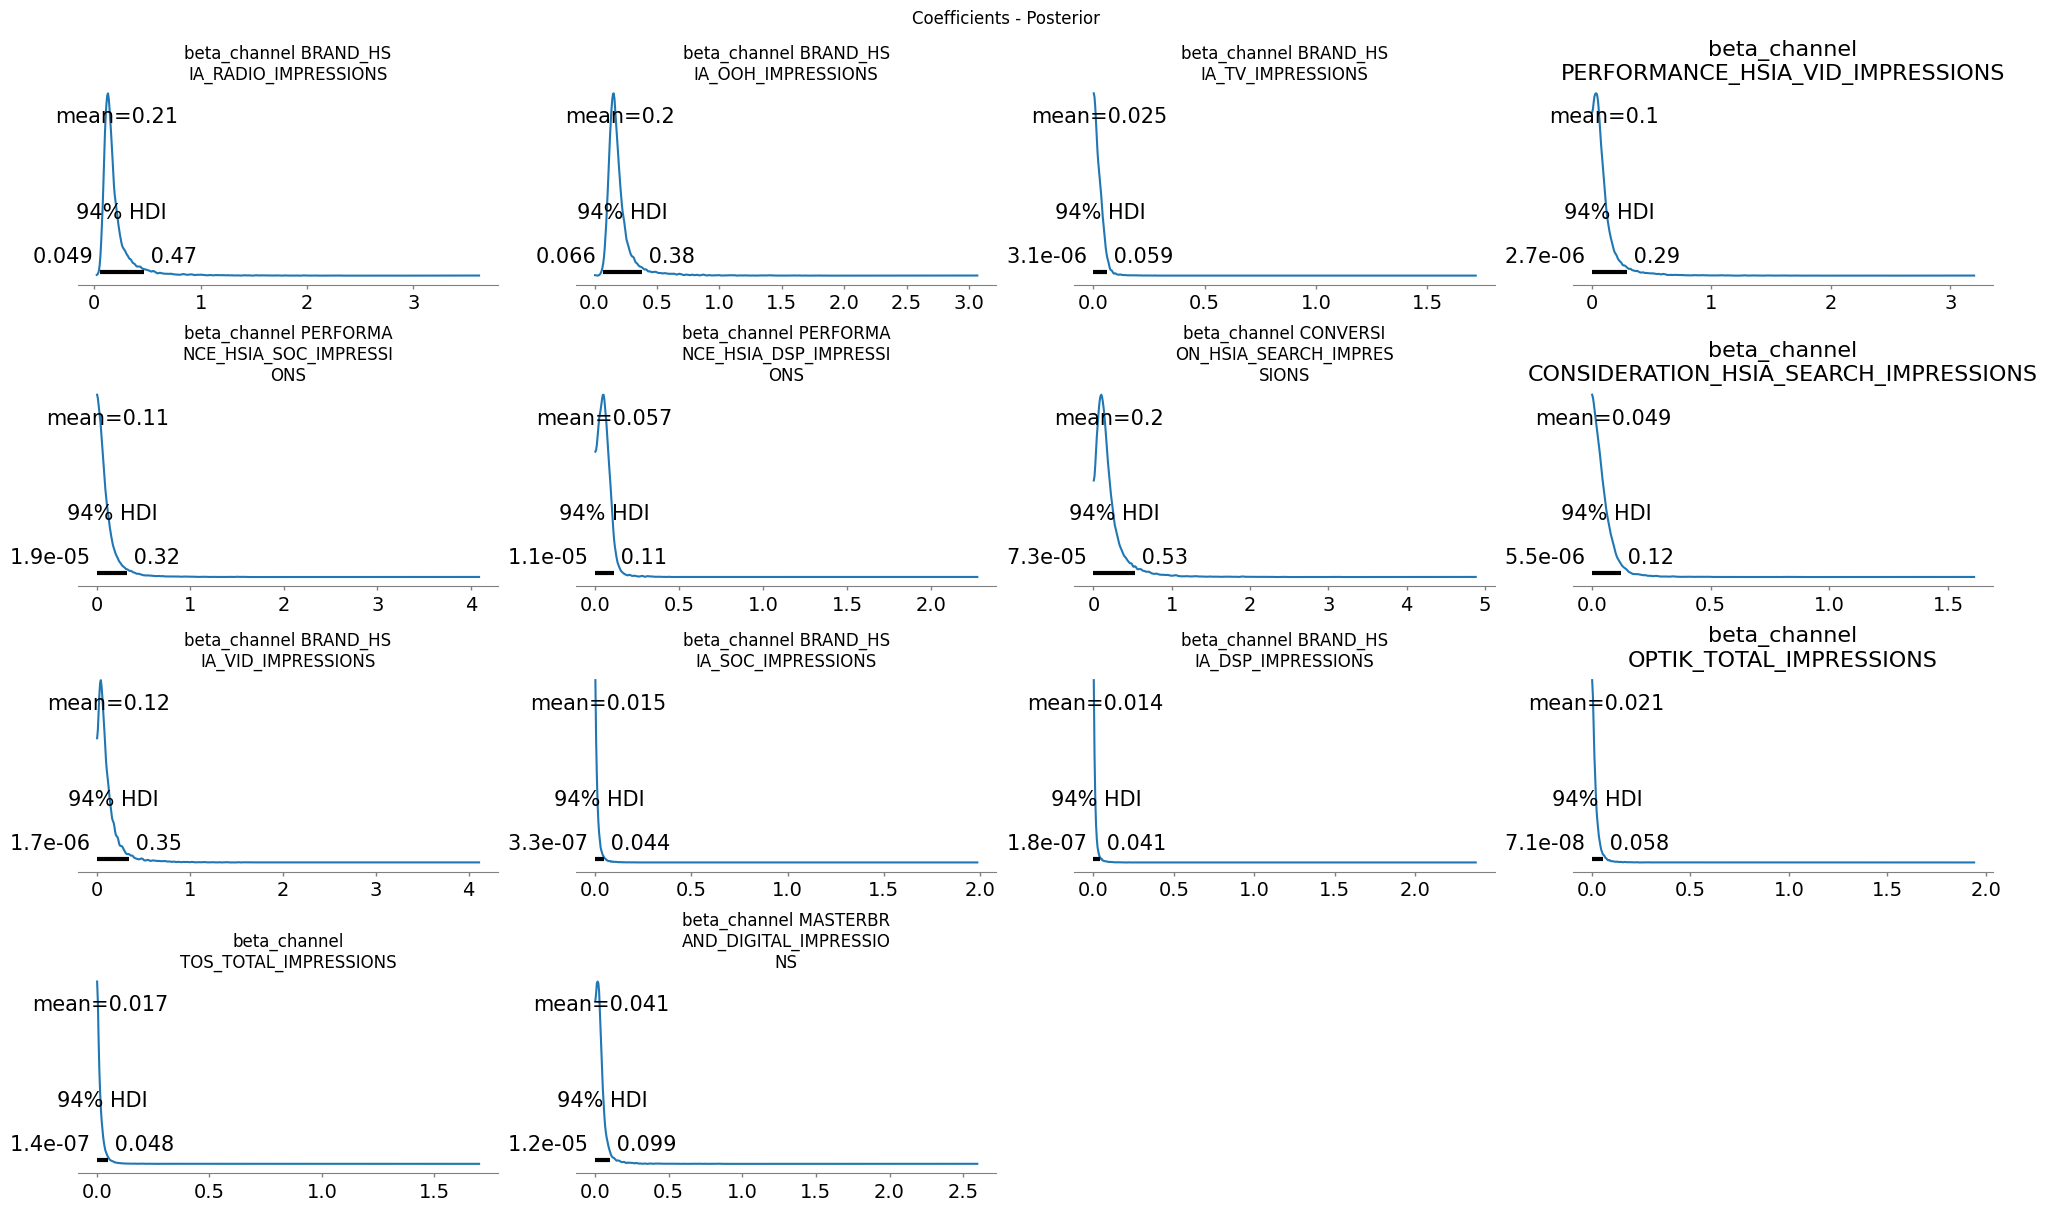

In [167]:
import textwrap

axes = az.plot_posterior(
    data=trace,
    var_names=["beta_channel"],
    backend_kwargs={
        "figsize": (20, 12),
        "layout": "constrained",
    },
)
for i in range(4):
    for j in range(3):
        t = textwrap.fill(axes[i][j].get_title(),21)
        axes[i][j].set_title(t)
        
        
fig = axes[0][0].get_figure()


fig.suptitle("Coefficients - Posterior");

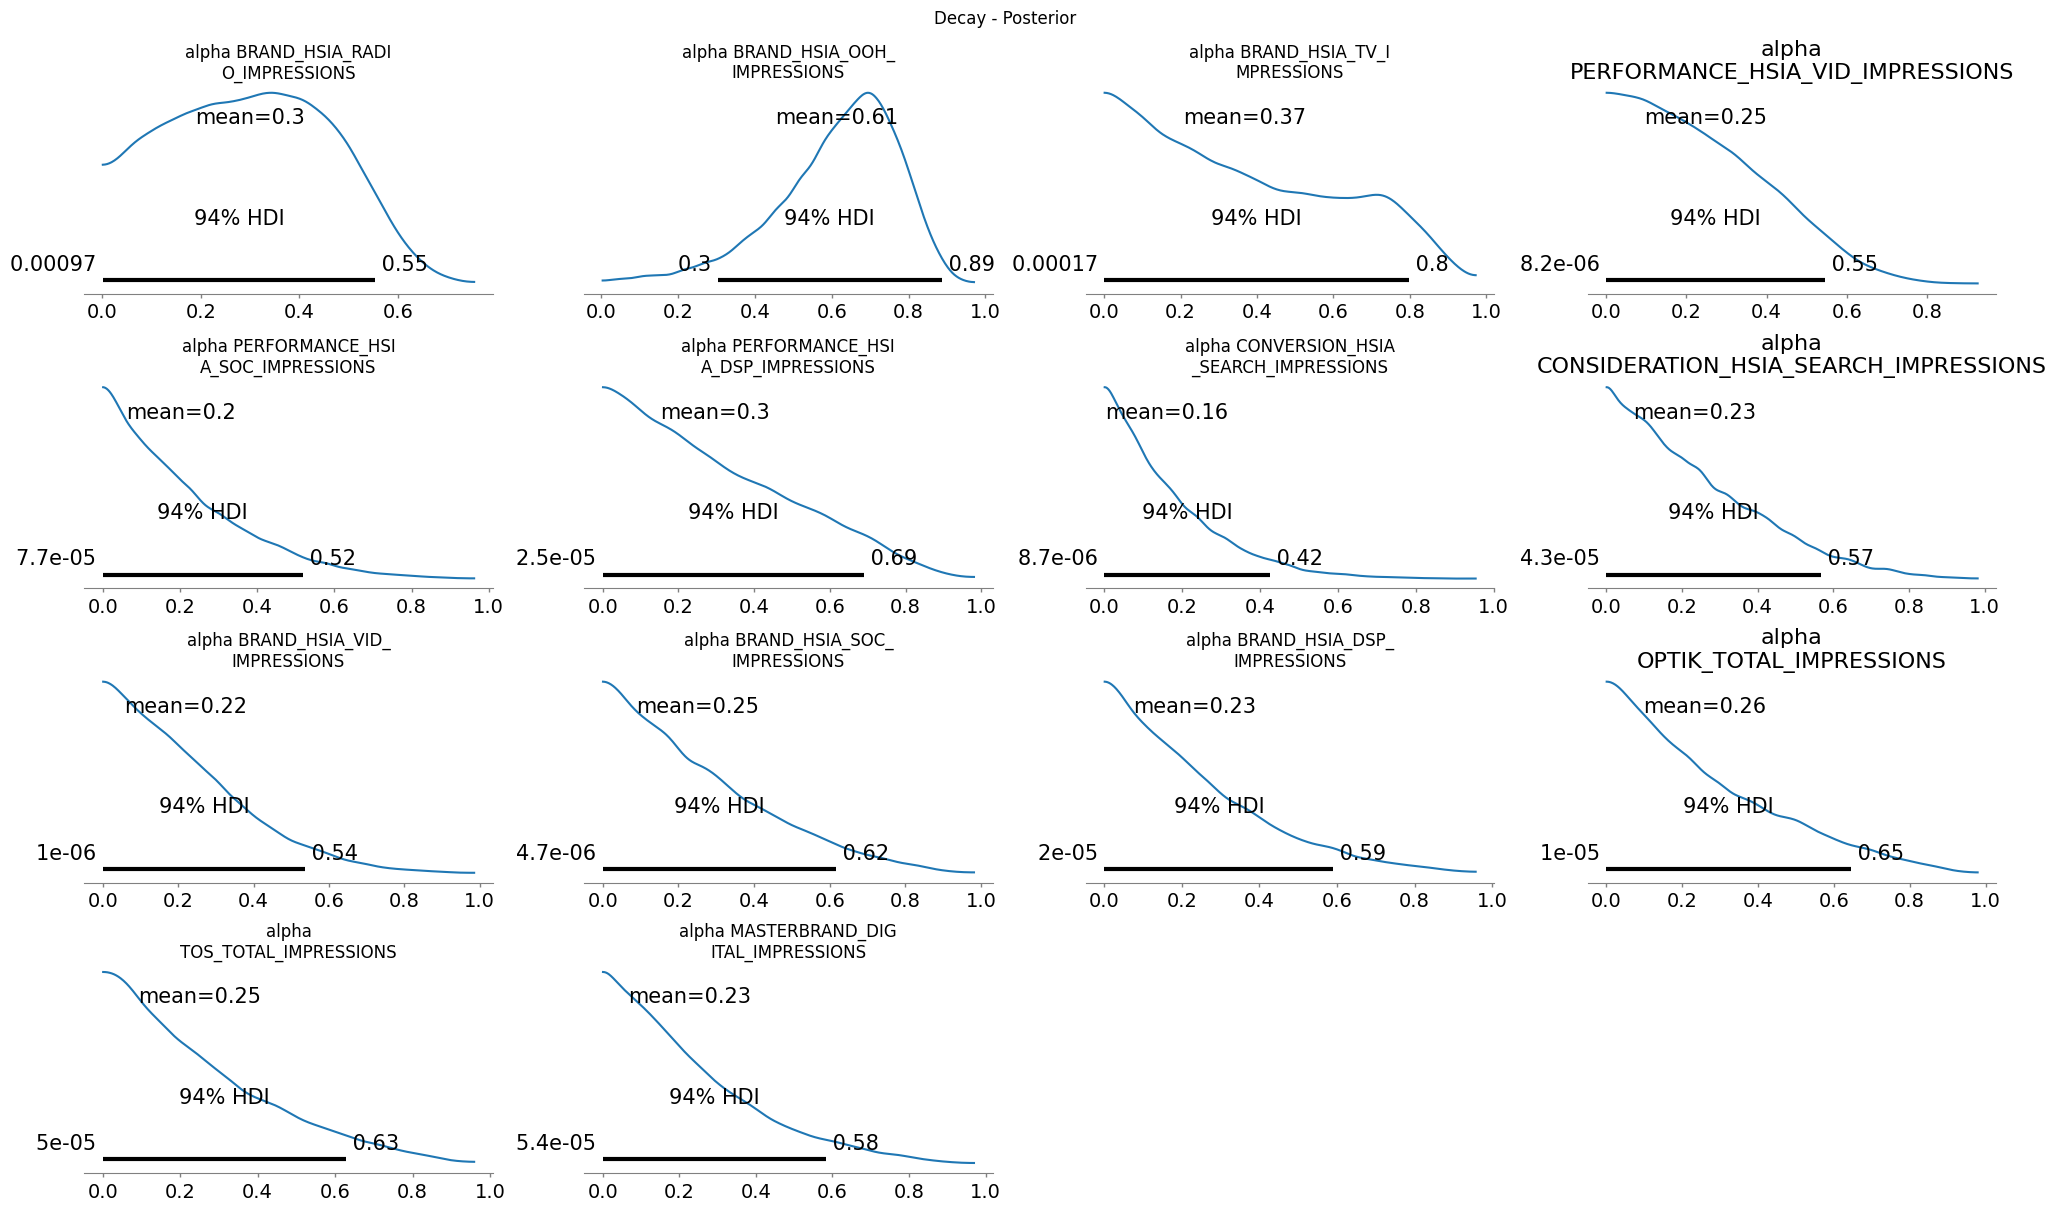

In [168]:
import textwrap

axes = az.plot_posterior(
    data=trace,
    var_names=['alpha'],
    backend_kwargs={
        "figsize": (20, 12),
        "layout": "constrained",
    },
)
for i in range(4):
    for j in range(3):
        t = textwrap.fill(axes[i][j].get_title(),21)
        axes[i][j].set_title(t)
        
        
fig = axes[0][0].get_figure()
fig.suptitle("Decay - Posterior");

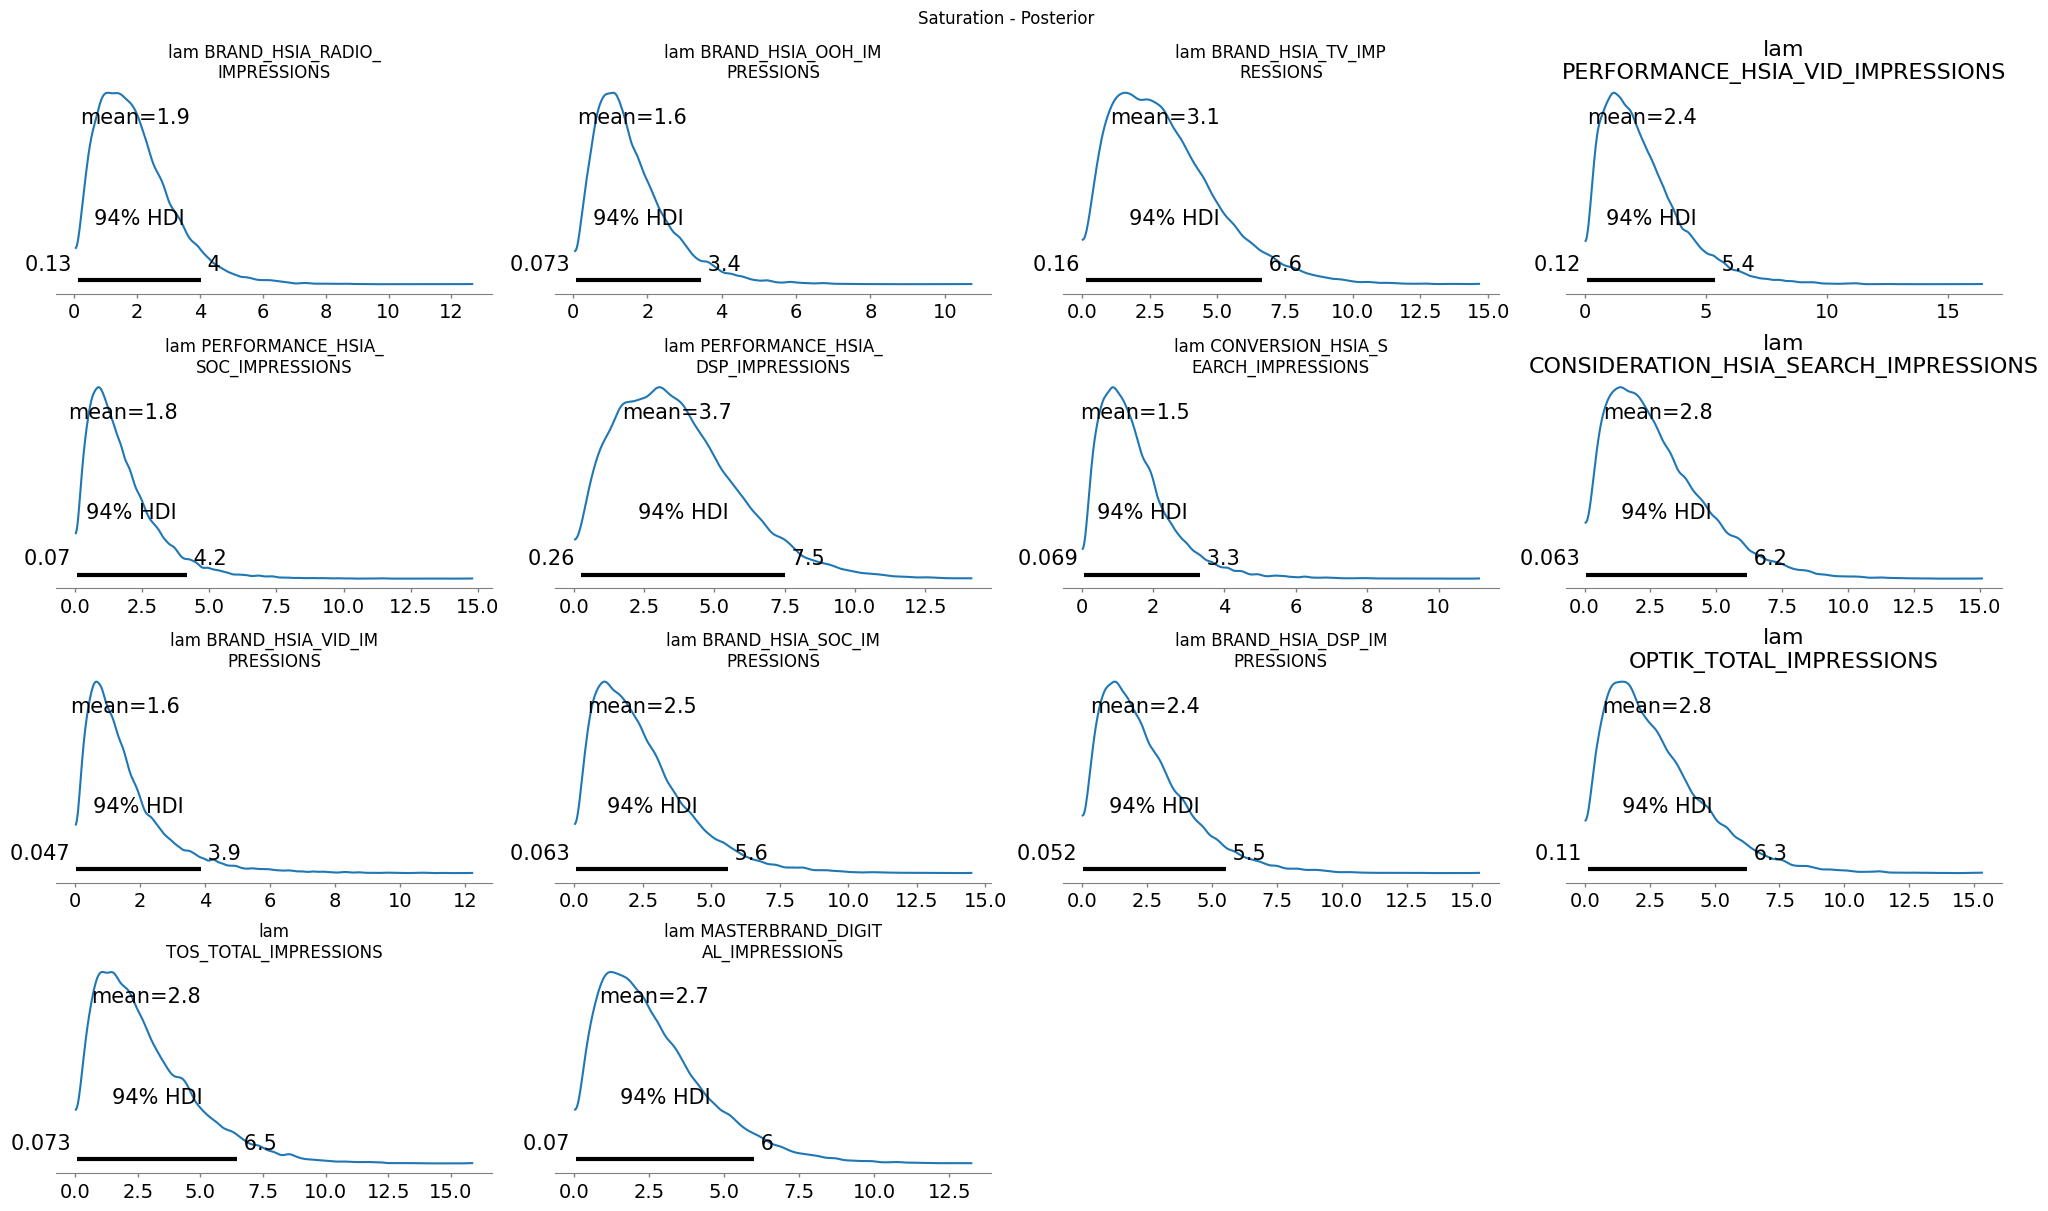

In [169]:
import textwrap

axes = az.plot_posterior(
    data=trace,
    var_names=['lam'],
    backend_kwargs={
        "figsize": (20, 12),
        "layout": "constrained",
    },
)
for i in range(4):
    for j in range(3):
        t = textwrap.fill(axes[i][j].get_title(),21)
        axes[i][j].set_title(t)
        
        
fig = axes[0][0].get_figure()
fig.suptitle("Saturation - Posterior");

# Plotting Posterior Contributions

## 1 i) Estimated Coefficients

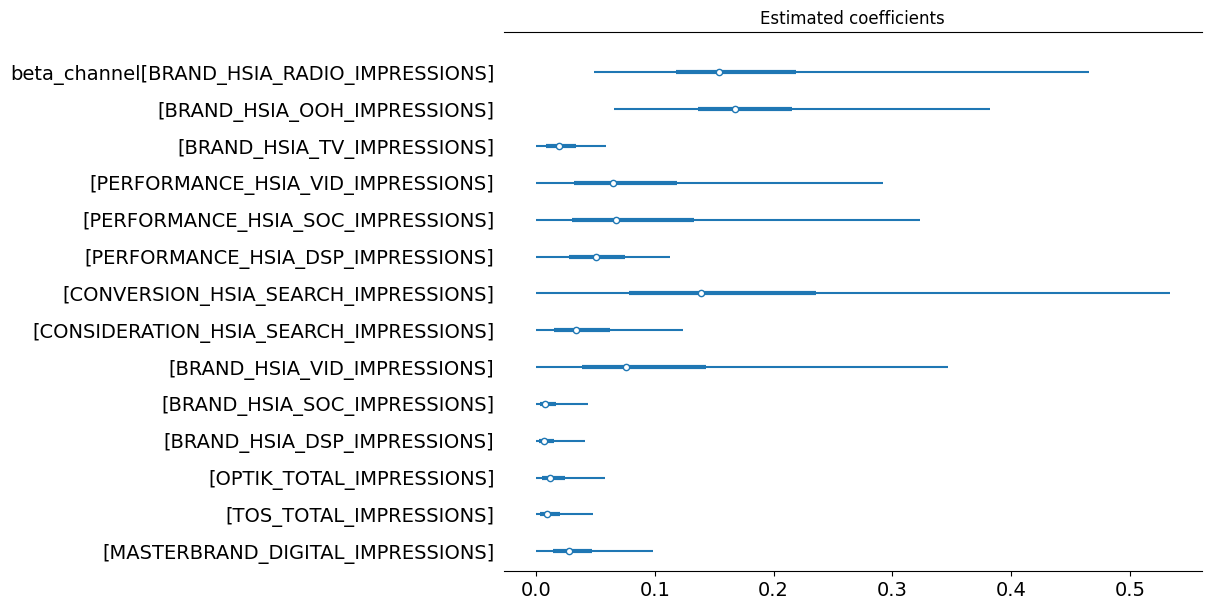

In [170]:
#https://python.arviz.org/en/stable/api/generated/arviz.plot_forest.html
axes = az.plot_forest(trace,
              var_names = ['beta_channel'],
               combined = True,
                hdi_prob = 0.94,
               figsize=(9, 7)
              )
axes[0].set_title('Estimated coefficients')
plt.show()

## 1 ii)  Estimated Alpha - Decay

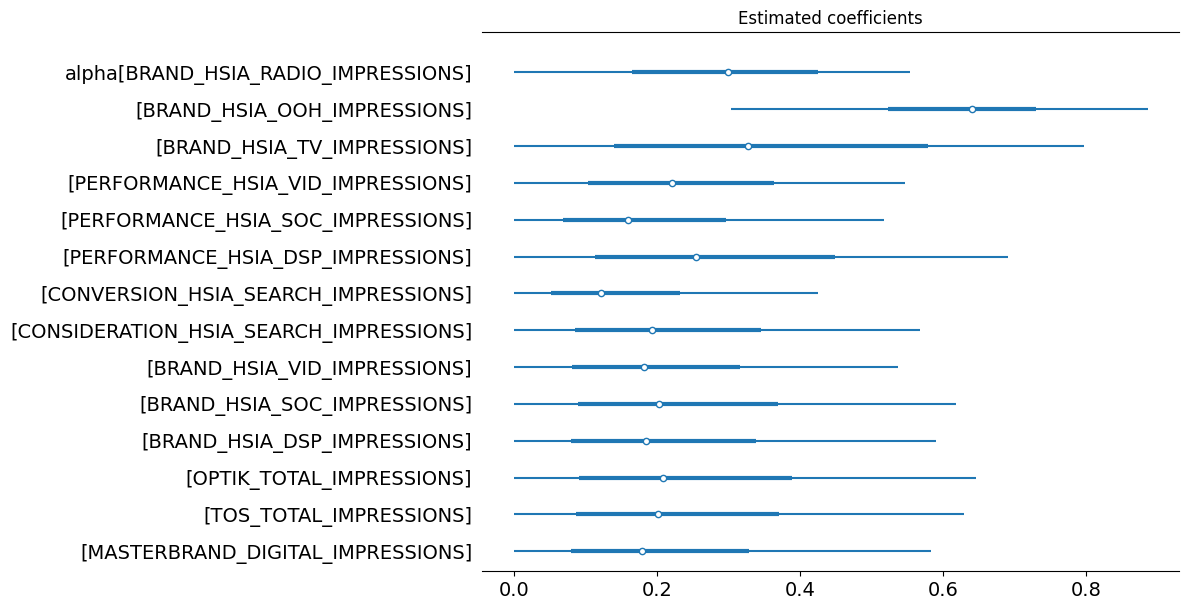

In [171]:
axes = az.plot_forest(trace,
              var_names = ['alpha'],
               combined = True,
                hdi_prob = 0.94,
               figsize=(9, 7)
              )
axes[0].set_title('Estimated coefficients')
plt.show()

## 1) iii) Estimated Lam - Saturation

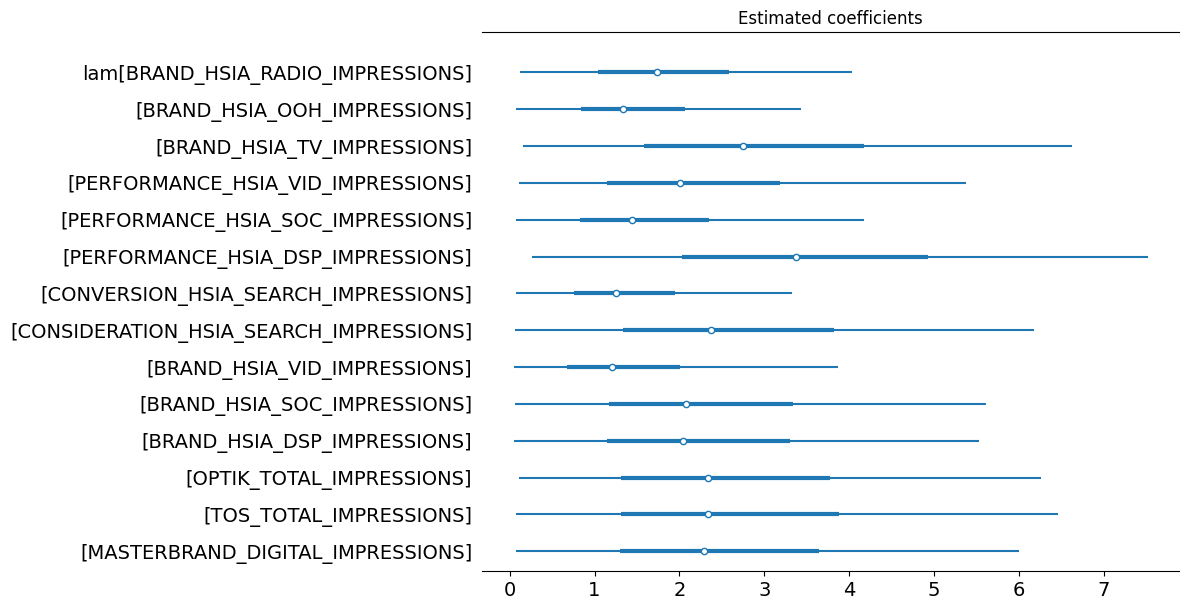

In [172]:
axes = az.plot_forest(trace,
              var_names = ['lam'],
               combined = True,
                hdi_prob = 0.94,
               figsize=(9, 7)
              )
axes[0].set_title('Estimated coefficients')
plt.show()

In [173]:
'''
Refer to https://github.com/pymc-labs/pymc-marketing/blob/main/pymc_marketing/mmm/base.py

'''

def compute_channel_contribution_original_scale(trace) -> DataArray:
        channel_contribution = az.extract(
            data=trace, var_names=["channel_contributions"], combined=False
        )

        # sklearn preprocessers expect 2-D arrays of (obs, features)
        # We need to treat all entries of channel_contribution as independent obs
        # so we flatten it, then apply the transform, and finally reshape back into its
        # original form
        return DataArray(
            np.reshape(
                scaler_df.loc[label].values[0].inverse_transform(
                    channel_contribution.data.flatten()[:, None]
                ),
                channel_contribution.shape,
            ),
            dims=channel_contribution.dims,
            coords=channel_contribution.coords,
        )
    
def _get_channel_contributions_share_samples(trace) -> DataArray:
    channel_contribution_original_scale_samples: DataArray = (
            compute_channel_contribution_original_scale(trace)
        )
    numerator: DataArray = channel_contribution_original_scale_samples.sum(["date"])
    denominator: DataArray = numerator.sum("channel")
    return numerator / denominator


def plot_channel_contribution_share_hdi(
        trace, hdi_prob: float = 0.94, **plot_kwargs: Any
    ) -> plt.Figure:
    channel_contributions_share: DataArray = (
            _get_channel_contributions_share_samples(trace)
        )

    ax, *_ = az.plot_forest(
            data=channel_contributions_share,
            combined=True,
            hdi_prob=hdi_prob,
            backend_kwargs=plot_kwargs,
            figsize=(9, 7)
    )
    ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: f"{y: 0.0%}"))
    fig: plt.Figure = plt.gcf()
    fig.suptitle("Channel Contribution Share", fontsize=16, y=1.05)
    plt.savefig('channel_cont_share_hdi.png')
    #return fig

## 2) Estimated Channel Contribution Share

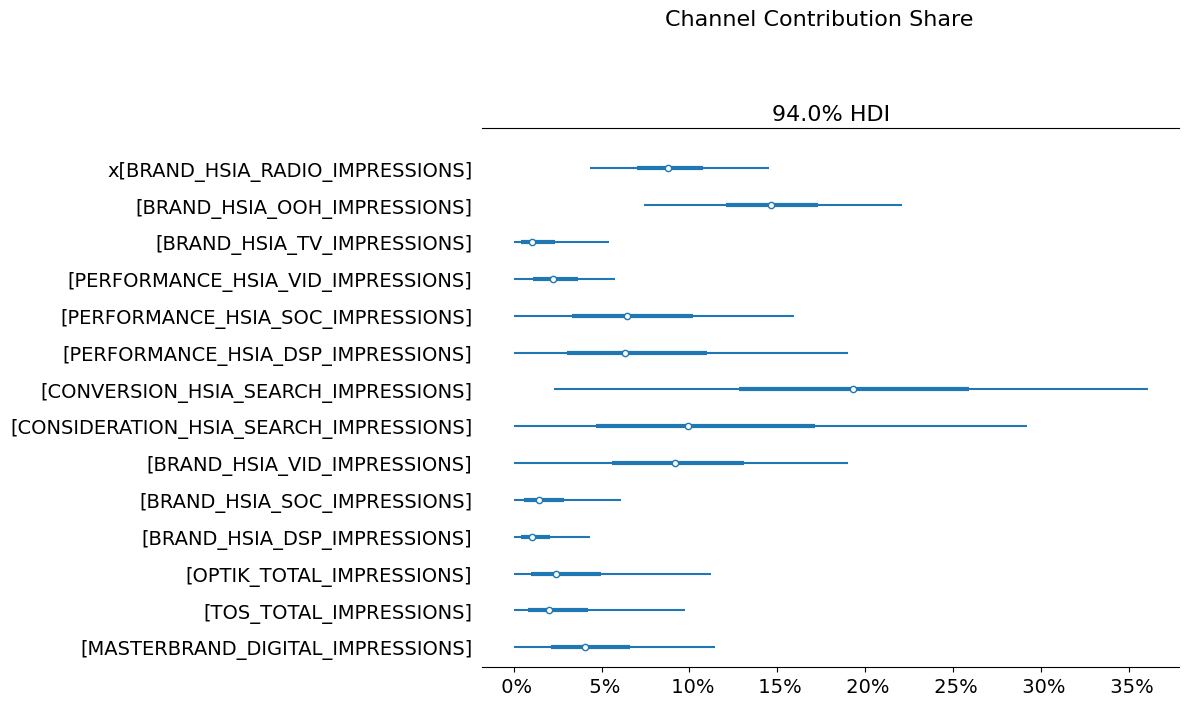

In [174]:
plot_channel_contribution_share_hdi(trace)

## 3) Spend Share vs Effect Share as a point estimate

In [183]:
channel_contribution = az.extract(
            data=trace, var_names=["channel_contributions"], combined=True
        ).sum('date')

'''

Since the channel contributions are in the scale of the label, we use the label scaler to inverse transform 
channel contributions into the original scale. We format it as a DataArray with dims and coords for easy grouping and summing.


'''
channel_contribution_original_scale = DataArray(
            np.reshape(
                scaler_df.loc[label].values[0].inverse_transform(
                    channel_contribution.data.flatten()[:, None]
                ),
                channel_contribution.shape,
            ),
            dims=channel_contribution.dims,
            coords=channel_contribution.coords,
        )

#Numerator is the channel contribution 
numerator: DataArray = channel_contribution_original_scale 

#Denominator is the total contribution summed by channel
denominator: DataArray = numerator.sum("channel")
    
#To calculate the channel share as a point estimate we calculate the mean over all the samples 
channel_share = (numerator/denominator).mean('sample').values

channel_names = (numerator/denominator).mean('sample')['channel'].values


In [184]:
spends = pd.read_excel('HS_MV.xlsx',sheet_name = None)
spends.keys()

dict_keys(['HS_MV', 'HS MV Updated with Spends (for ', 'HS MV Updated with Spends (V2)'])

In [185]:
spends = spends['HS MV Updated with Spends (V2)'].set_index('DATE').fillna(0)
spends  = spends.apply(pd.to_numeric)

In [187]:
spends['OPTIK_TOTAL_SPENDS']=spends[[x for x in spends.columns if ('OPTIK' in x) & ('SPENDS' in x)]].sum(axis=1)
spends['TOS_TOTAL_SPENDS']=spends[[x for x in spends.columns if ('TOS' in x) & ('SPENDS' in x)]].sum(axis=1)
spends['MASTERBRAND_TVRADIO_TOTAL_SPENDS']=spends[[x for x in spends.columns if ('MASTERBRAND' in x) & ('SPENDS' in x) & any([y in x for y in ['TV','RADIO']])]].sum(axis=1)
spends['MASTERBRAND_DIGITAL_SPENDS']=spends[[x for x in spends.columns if ('MASTERBRAND' in x) & ('SPENDS' in x) & all([y not in x for y in ['TV','RADIO','OOH']])]].sum(axis=1)
#spends['TV_INTERNETxBRAND_SPENDS'] = spends[["BRAND_INTERNET_VID_SPENDS","BRAND_INTERNET_SOC_SPENDS","BRAND_INTERNET_DSP_SPENDS"]].sum(axis=1)*spends['TV_INTERNET']
#spends['TV_INTERNETxTV_MB_SPENDS'] = spends[['MASTERBRAND_TV_FR_SPENDS','MASTERBRAND_RADIO_EN_SPENDS']].sum(axis=1)*data['TV_INTERNET']
#spends['TV_INTERNETxSEARCH_SPENDS'] = spends[['CONSIDERATION_INTERNET_SEARCH_SPENDS','CONVERSION_INTERNET_SEARCH_SPENDS']].sum(axis=1)*spends['TV_INTERNET']
#spends['TV_INTERNETxPERFORMANCE_SPENDS'] = spends[['PERFORMANCE_INTERNET_DSP_SPENDS','PERFORMANCE_INTERNET_SOC_SPENDS','PERFORMANCE_INTERNET_VID_SPENDS']].sum(axis=1)*spends['TV_INTERNET']

In [188]:
# spend_cols specifies what columns we need spend for according to the channel_names in the model 
spend_cols = [x.replace("IMPRESSIONS","SPENDS") for x in channel_names]
spend_cols

['BRAND_HSIA_RADIO_SPENDS',
 'BRAND_HSIA_OOH_SPENDS',
 'BRAND_HSIA_TV_SPENDS',
 'PERFORMANCE_HSIA_VID_SPENDS',
 'PERFORMANCE_HSIA_SOC_SPENDS',
 'PERFORMANCE_HSIA_DSP_SPENDS',
 'CONVERSION_HSIA_SEARCH_SPENDS',
 'CONSIDERATION_HSIA_SEARCH_SPENDS',
 'BRAND_HSIA_VID_SPENDS',
 'BRAND_HSIA_SOC_SPENDS',
 'BRAND_HSIA_DSP_SPENDS',
 'OPTIK_TOTAL_SPENDS',
 'TOS_TOTAL_SPENDS',
 'MASTERBRAND_DIGITAL_SPENDS']

In [189]:
hsia_spends = spends.filter(spend_cols,axis=1)

# Makes sure that the spends are all numeric 
hsia_spends = hsia_spends.apply(pd.to_numeric, errors='coerce')
hsia_spends.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 104 entries, 2021-01-03 to 2022-12-25
Data columns (total 14 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   BRAND_HSIA_RADIO_SPENDS           104 non-null    float64
 1   BRAND_HSIA_OOH_SPENDS             104 non-null    float64
 2   BRAND_HSIA_TV_SPENDS              104 non-null    float64
 3   PERFORMANCE_HSIA_VID_SPENDS       104 non-null    float64
 4   PERFORMANCE_HSIA_SOC_SPENDS       104 non-null    float64
 5   PERFORMANCE_HSIA_DSP_SPENDS       104 non-null    float64
 6   CONVERSION_HSIA_SEARCH_SPENDS     104 non-null    float64
 7   CONSIDERATION_HSIA_SEARCH_SPENDS  104 non-null    float64
 8   BRAND_HSIA_VID_SPENDS             104 non-null    float64
 9   BRAND_HSIA_SOC_SPENDS             104 non-null    float64
 10  BRAND_HSIA_DSP_SPENDS             104 non-null    float64
 11  OPTIK_TOTAL_SPENDS                104 non-null    fl

In [190]:
# Sum spend by channel
channel_spends = hsia_spends.sum(axis=0,numeric_only=True)

#Reset the index so it matches the channel share index for easy concatenation 
channel_spends.index = [x.replace('SPENDS','IMPRESSIONS') for x in channel_spends.index.to_list()]
channel_spends = channel_spends.rename("Channel Spends")
channel_spends = channel_spends/channel_spends.sum()

In [191]:
# Create a dataframe containing channel names, channel shares and then concatenate with channel spends 
channel_share_df = pd.DataFrame({'Channel Names':channel_names, 'Channel Shares':channel_share}).set_index('Channel Names')
channel_share_df = pd.concat([channel_share_df,channel_spends],axis=1)
channel_share_df.sort_values('Channel Shares',inplace=True)
channel_share_df

Channel Shares  Channel Spends
BRAND_HSIA_DSP_IMPRESSIONS                   0.015349        0.008144
BRAND_HSIA_TV_IMPRESSIONS                    0.017253        0.005690
BRAND_HSIA_SOC_IMPRESSIONS                   0.021088        0.020052
PERFORMANCE_HSIA_VID_IMPRESSIONS             0.025612        0.000127
TOS_TOTAL_IMPRESSIONS                        0.032990        0.124416
OPTIK_TOTAL_IMPRESSIONS                      0.037757        0.734391
MASTERBRAND_DIGITAL_IMPRESSIONS              0.049546        0.055691
PERFORMANCE_HSIA_SOC_IMPRESSIONS             0.072201        0.005289
PERFORMANCE_HSIA_DSP_IMPRESSIONS             0.077491        0.003754
BRAND_HSIA_RADIO_IMPRESSIONS                 0.090379        0.001655
BRAND_HSIA_VID_IMPRESSIONS                   0.097171        0.010965
CONSIDERATION_HSIA_SEARCH_IMPRESSIONS        0.120301        0.012911
BRAND_HSIA_OOH_IMPRESSIONS                   0.147694        0.004869
CONVERSION_HSIA_SEARCH_IMPRESSIONS           0.195169        0.012047

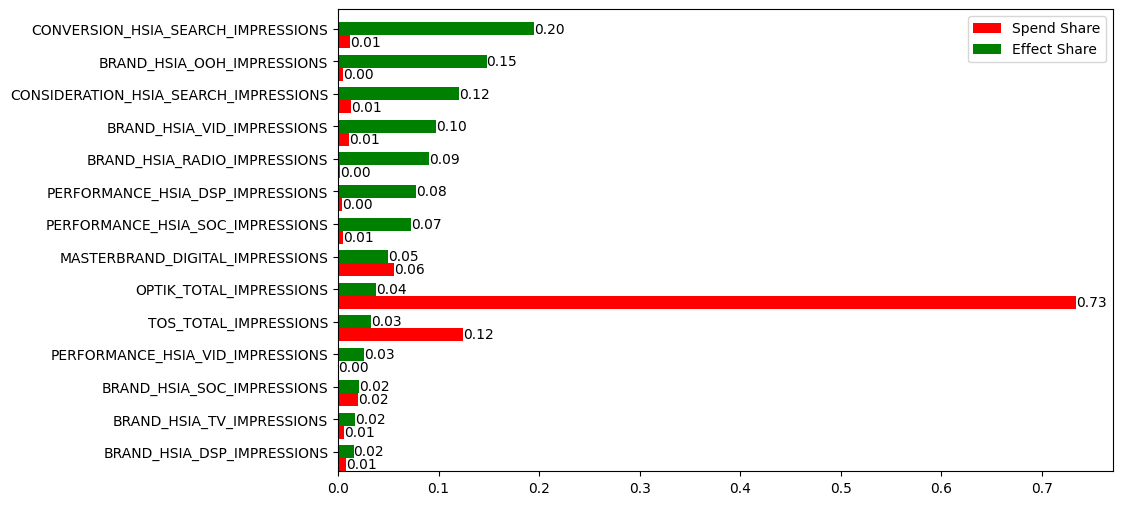

In [192]:
#https://stackoverflow.com/questions/15201386/how-to-plot-multiple-horizontal-bars-in-one-chart-with-matplotlib
#https://stackoverflow.com/questions/30228069/how-to-display-the-value-of-the-bar-on-each-bar-with-pyplot-barh

ind = np.arange(len(channel_share_df))
width = 0.4

fig, ax = plt.subplots()
ax.barh(ind, channel_share_df['Channel Spends'], width, color='red', label='Spend Share')
ax.barh(ind + width, channel_share_df['Channel Shares'], width, color='green', label='Effect Share')

ax.set(yticks=ind + width, yticklabels=channel_share_df.index, ylim=[2*width - 1, len(channel_share_df)])
ax.legend()

for bars in ax.containers:
    ax.bar_label(bars,labels=[f'{x:,.2f}' for x in bars.datavalues])

plt.savefig('effect_spend_share.png')
plt.show()

## Internet Only 

In [194]:
channel_spends = hsia_spends.sum(axis=0,numeric_only=True)

#Reset the index so it matches the channel share index for easy concatenation 
channel_spends.index = [x.replace('SPENDS','IMPRESSIONS') for x in channel_spends.index.to_list()]
channel_spends = channel_spends.rename("Channel Spends")

In [195]:
channel_spends = channel_spends.loc[[x for x in media if 'HSIA' in x]]
channel_spends = channel_spends/channel_spends.sum()

In [196]:
#Numerator is the channel contribution 
numerator: DataArray = channel_contribution_original_scale.loc[[x for x in media if 'HSIA' in x]]

#Denominator is the total contribution summed by channel
denominator: DataArray = numerator.sum("channel")
    
#To calculate the channel share as a point estimate we calculate the mean over all the samples 
channel_share = (numerator/denominator).mean('sample').values

channel_names = (numerator/denominator).mean('sample')['channel'].values

# Create a dataframe containing channel names, channel shares and then concatenate with channel spends 
channel_share_df = pd.DataFrame({'Channel Names':channel_names, 'Channel Shares':channel_share}).set_index('Channel Names')
channel_share_df = pd.concat([channel_share_df,channel_spends],axis=1)
channel_share_df.sort_values('Channel Shares',inplace=True)
channel_share_df

Channel Shares  Channel Spends
BRAND_HSIA_DSP_IMPRESSIONS                   0.017482        0.095254
BRAND_HSIA_TV_IMPRESSIONS                    0.019644        0.066551
BRAND_HSIA_SOC_IMPRESSIONS                   0.024037        0.234518
PERFORMANCE_HSIA_VID_IMPRESSIONS             0.029043        0.001482
PERFORMANCE_HSIA_SOC_IMPRESSIONS             0.082222        0.061862
PERFORMANCE_HSIA_DSP_IMPRESSIONS             0.088230        0.043902
BRAND_HSIA_RADIO_IMPRESSIONS                 0.103192        0.019354
BRAND_HSIA_VID_IMPRESSIONS                   0.110527        0.128248
CONSIDERATION_HSIA_SEARCH_IMPRESSIONS        0.135440        0.150997
BRAND_HSIA_OOH_IMPRESSIONS                   0.168313        0.056941
CONVERSION_HSIA_SEARCH_IMPRESSIONS           0.221869        0.140892

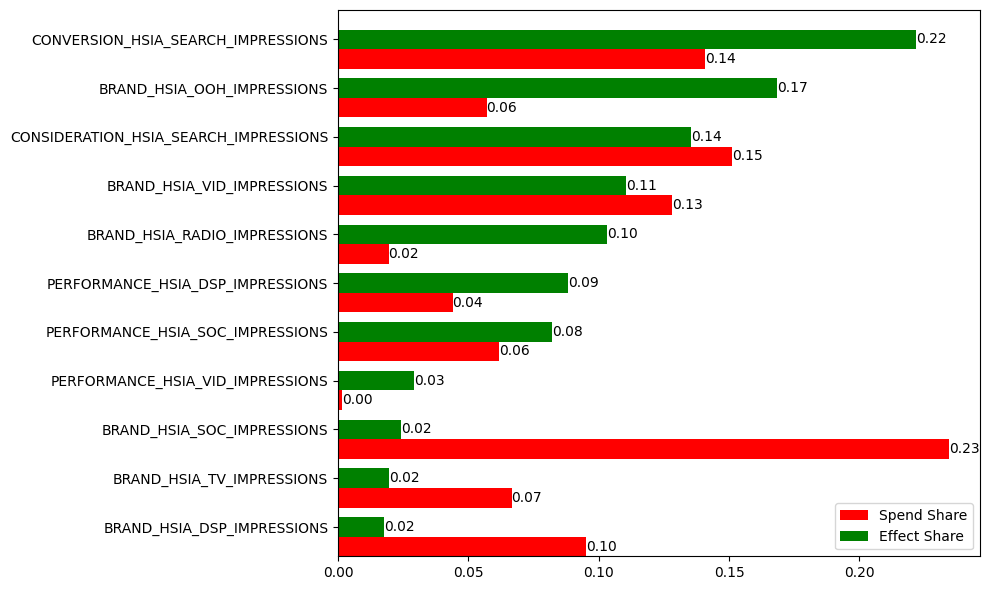

In [198]:
#https://stackoverflow.com/questions/15201386/how-to-plot-multiple-horizontal-bars-in-one-chart-with-matplotlib
#https://stackoverflow.com/questions/30228069/how-to-display-the-value-of-the-bar-on-each-bar-with-pyplot-barh

ind = np.arange(len(channel_share_df))
width = 0.4

fig, ax = plt.subplots()
ax.barh(ind, channel_share_df['Channel Spends'], width, color='red', label='Spend Share')
ax.barh(ind + width, channel_share_df['Channel Shares'], width, color='green', label='Effect Share')

ax.set(yticks=ind + width, yticklabels=channel_share_df.index, ylim=[2*width - 1, len(channel_share_df)])
ax.legend()

for bars in ax.containers:
    ax.bar_label(bars,labels=[f'{x:,.2f}' for x in bars.datavalues])

plt.tight_layout()

plt.savefig('effect_spend_share2.png')
plt.show()


## 4) Effect share of all variables (including intercept and control)

Same process as above but including all variables this time. 

In [199]:
contribution = az.extract(
            data=trace, var_names=["channel_contributions","control_contributions","intercept"], combined=True
        ).sum('date')
channel_contributions = contribution.channel_contributions
control_contributions = contribution.control_contributions
intercept_contributions = contribution.intercept*scaled_data_df.shape[0]
total_contributions = np.vstack((channel_contributions.data,control_contributions.data,intercept_contributions.data))
new_coords= {'var': contribution.coords['channel'].values.tolist()+ contribution.coords['control'].values.tolist()+['Intercept']}

In [200]:
channel_contribution_original_scale = DataArray(
            np.reshape(
                scaler_df.loc[label].values[0].inverse_transform(
                    total_contributions.flatten()[:, None]
                ),
                total_contributions.shape,
            ),
            dims=('var','sample'),
            coords=new_coords,
        )
numerator: DataArray = channel_contribution_original_scale

denominator: DataArray = numerator.sum("var")
    
channel_share = (numerator/denominator).mean('sample').values

channel_names = (numerator/denominator).mean('sample')['var'].values

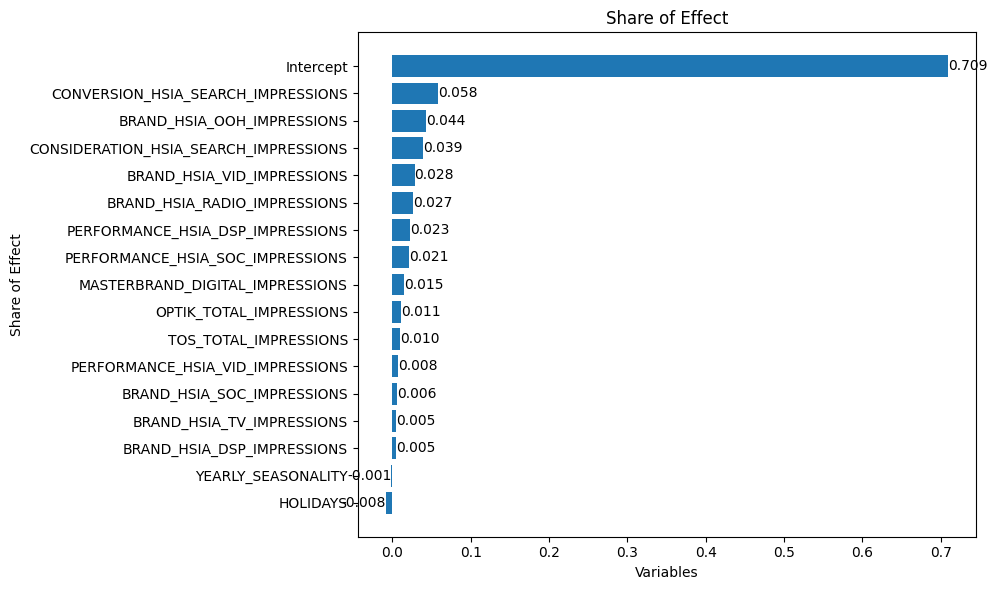

In [201]:
channel_share_df = pd.DataFrame({'Channel Names':channel_names, 'Channel Shares':channel_share})
channel_share_df.sort_values('Channel Shares',inplace=True)
fig, ax = plt.subplots()

hbars = ax.barh(channel_share_df[['Channel Names']].values.flatten(),channel_share_df[['Channel Shares']].values.flatten())
ax.set_title("Share of Effect")
ax.set_xlabel("Variables")
ax.set_ylabel("Share of Effect")
ax.bar_label(hbars, fmt='%.3f')

plt.tight_layout()
plt.savefig('Contribution.png')
plt.show()

# Out-of-Sample Predictions

Create out-of-sample predictions to see how well our model describes data it hasn't seen before.

In [202]:
data_test = data[(data['Date']>'2022-09-25')][columns_to_keep+['Date']]
data_test.head()

HSIA_RGU_ACTUAL_VOLUME  BRAND_HSIA_RADIO_IMPRESSIONS  \
91                    6818                             0   
92                    4881                             0   
93                    5119                             0   
94                    4906                             0   
95                    6353                       1015750   

    BRAND_HSIA_OOH_IMPRESSIONS  BRAND_HSIA_TV_IMPRESSIONS  \
91                      724117                          0   
92                      724117                          0   
93                      724117                          0   
94                      724117                          0   
95                      724117                          0   

    PERFORMANCE_HSIA_VID_IMPRESSIONS  PERFORMANCE_HSIA_SOC_IMPRESSIONS  \
91                                 0                           2314334   
92                                 0                           2004114   
93                                 0                           1594910   
94                                 0                           1486260   
95                                 0                           1519924   

    PERFORMANCE_HSIA_DSP_IMPRESSIONS  CONVERSION_HSIA_SEARCH_IMPRESSIONS  \
91                           3937892                              138324   
92                           3326922                              133884   
93                           3188782                               91771   
94                           3023548                               72213   
95                           2954954                               92817   

    CONSIDERATION_HSIA_SEARCH_IMPRESSIONS  BRAND_HSIA_VID_IMPRESSIONS  \
91                                  82950                     3742636   
92                                  74944                     3746052   
93                                  87910                     3474014   
94                                 107791                     3193726   
95                                 109550                     3129746   

    BRAND_HSIA_SOC_IMPRESSIONS  BRAND_HSIA_DSP_IMPRESSIONS  \
91                     7752908                    12190638   
92                     6756232                    11210856   
93                     6477804                    10964300   
94                     6316767                    11527404   
95                     6777385                    14315756   

    OPTIK_TOTAL_IMPRESSIONS  TOS_TOTAL_IMPRESSIONS  \
91                 28199443               17181872   
92                 29866208               21882657   
93                 28478982               25156642   
94                 26849673               36224591   
95                 25317641               34651492   

    MASTERBRAND_DIGITAL_IMPRESSIONS    HOLIDAYS  YEARLY_SEASONALITY       Date  
91                         16589907    0.000000         1067.007563 2022-10-02  
92                         16154592    0.000000         -290.426857 2022-10-09  
93                         28475674  304.780169         -450.703806 2022-10-16  
94                         31229814    0.000000         -504.962160 2022-10-23  
95                         33534701    0.000000          915.817043 2022-10-30

In [203]:
# Use the original scalers in scaler_df to transform media variables in the test set 
scaled_data_test = []

for col in scaler_df.index.to_list():
    scaler = scaler_df.loc[col].values[0]
    scaled = pd.Series(scaler.transform(data_test[col].to_numpy().reshape(-1, 1)).flatten())
    scaled.name = col
    scaled_data_test.append(scaled)

In [204]:
scaled_data_test_df = pd.concat(scaled_data_test, axis=1)
#scaled_data_test_df.insert(0, 'Date', data_test.Date)
#scaled_data_test_df.index = data_test.Date
scaled_data_test_df

HSIA_RGU_ACTUAL_VOLUME  BRAND_HSIA_RADIO_IMPRESSIONS  \
0                0.842248                      0.000000   
1                0.602965                      0.000000   
2                0.632366                      0.000000   
3                0.606053                      0.000000   
4                0.784805                      0.439330   
5                0.598271                      0.439330   
6                0.652996                      0.439330   
7                0.637554                      0.439330   
8                0.783941                      0.145326   

   BRAND_HSIA_OOH_IMPRESSIONS  BRAND_HSIA_TV_IMPRESSIONS  \
0                    0.067063                        0.0   
1                    0.067063                        0.0   
2                    0.067063                        0.0   
3                    0.067063                        0.0   
4                    0.067063                        0.0   
5                    0.067063                        0.0   
6                    0.067063                        0.0   
7                    0.067063                        0.0   
8                    0.067063                        0.0   

   PERFORMANCE_HSIA_VID_IMPRESSIONS  PERFORMANCE_HSIA_SOC_IMPRESSIONS  \
0                               0.0                          0.522643   
1                               0.0                          0.452587   
2                               0.0                          0.360177   
3                               0.0                          0.335640   
4                               0.0                          0.343243   
5                               0.0                          0.393444   
6                               0.0                          0.394134   
7                               0.0                          0.571907   
8                               0.0                          0.564859   

   PERFORMANCE_HSIA_DSP_IMPRESSIONS  CONVERSION_HSIA_SEARCH_IMPRESSIONS  \
0                          0.276844                            0.940359   
1                          0.233892                            0.910175   
2                          0.224180                            0.623881   
3                          0.212564                            0.490921   
4                          0.207741                            0.630992   
5                          0.164781                            0.652440   
6                          0.226221                            0.993732   
7                          0.170289                            1.044549   
8                          0.088330                            0.537489   

   CONSIDERATION_HSIA_SEARCH_IMPRESSIONS  BRAND_HSIA_VID_IMPRESSIONS  \
0                               0.732360                    0.327818   
1                               0.661675                    0.328117   
2                               0.776151                    0.304289   
3                               0.951679                    0.279739   
4                               0.967209                    0.274135   
5                               0.643965                    0.245058   
6                               0.585067                    0.431890   
7                               1.003417                    0.421765   
8                               0.675316                    0.158071   

   BRAND_HSIA_SOC_IMPRESSIONS  BRAND_HSIA_DSP_IMPRESSIONS  \
0                    0.645477                    0.360200   
1                    0.562497                    0.331251   
2                    0.539316                    0.323965   
3                    0.525909                    0.340604   
4                    0.564258                    0.422992   
5                    0.503198                    0.517543   
6                    0.284556                    0.509923   
7                    0.215497                    0.268383   
8                    0.319008                    0.143264  

## Generate predictions on test set

In [205]:
# Update data reference.
new_coords = {
    "date": data_test.Date,
    "channel": channel_data.columns,
    "control": control_data.columns
         }


with model:
    pm.set_data(new_data={"channel_data": scaled_data_test_df[media].to_numpy()},coords=new_coords)
    pm.set_data(new_data={"control_data": scaled_data_test_df[control].to_numpy()},coords=new_coords)
    pm.set_data(new_data={"target": scaled_data_test_df[[label]].to_numpy().flatten()},coords=new_coords)
    

In [206]:
ppc_test = pm.sample_posterior_predictive(trace, model=model)

Sampling: [outcome]


In [207]:
y_test_pred = scaler_df.loc[label].values[0].inverse_transform(
        X=az.extract(
            data=ppc_test,
            group="posterior_predictive",
            var_names=["outcome"],
        )).mean(axis=1)
y_test_actual = scaler_df.loc[label].values[0].inverse_transform(scaled_data_test_df[[label]].to_numpy()).flatten()

In [208]:
print (f"NRMSE of out-of-sample data is {nrmse(y_test_actual,y_test_pred)}")

NRMSE of out-of-sample data is 0.14


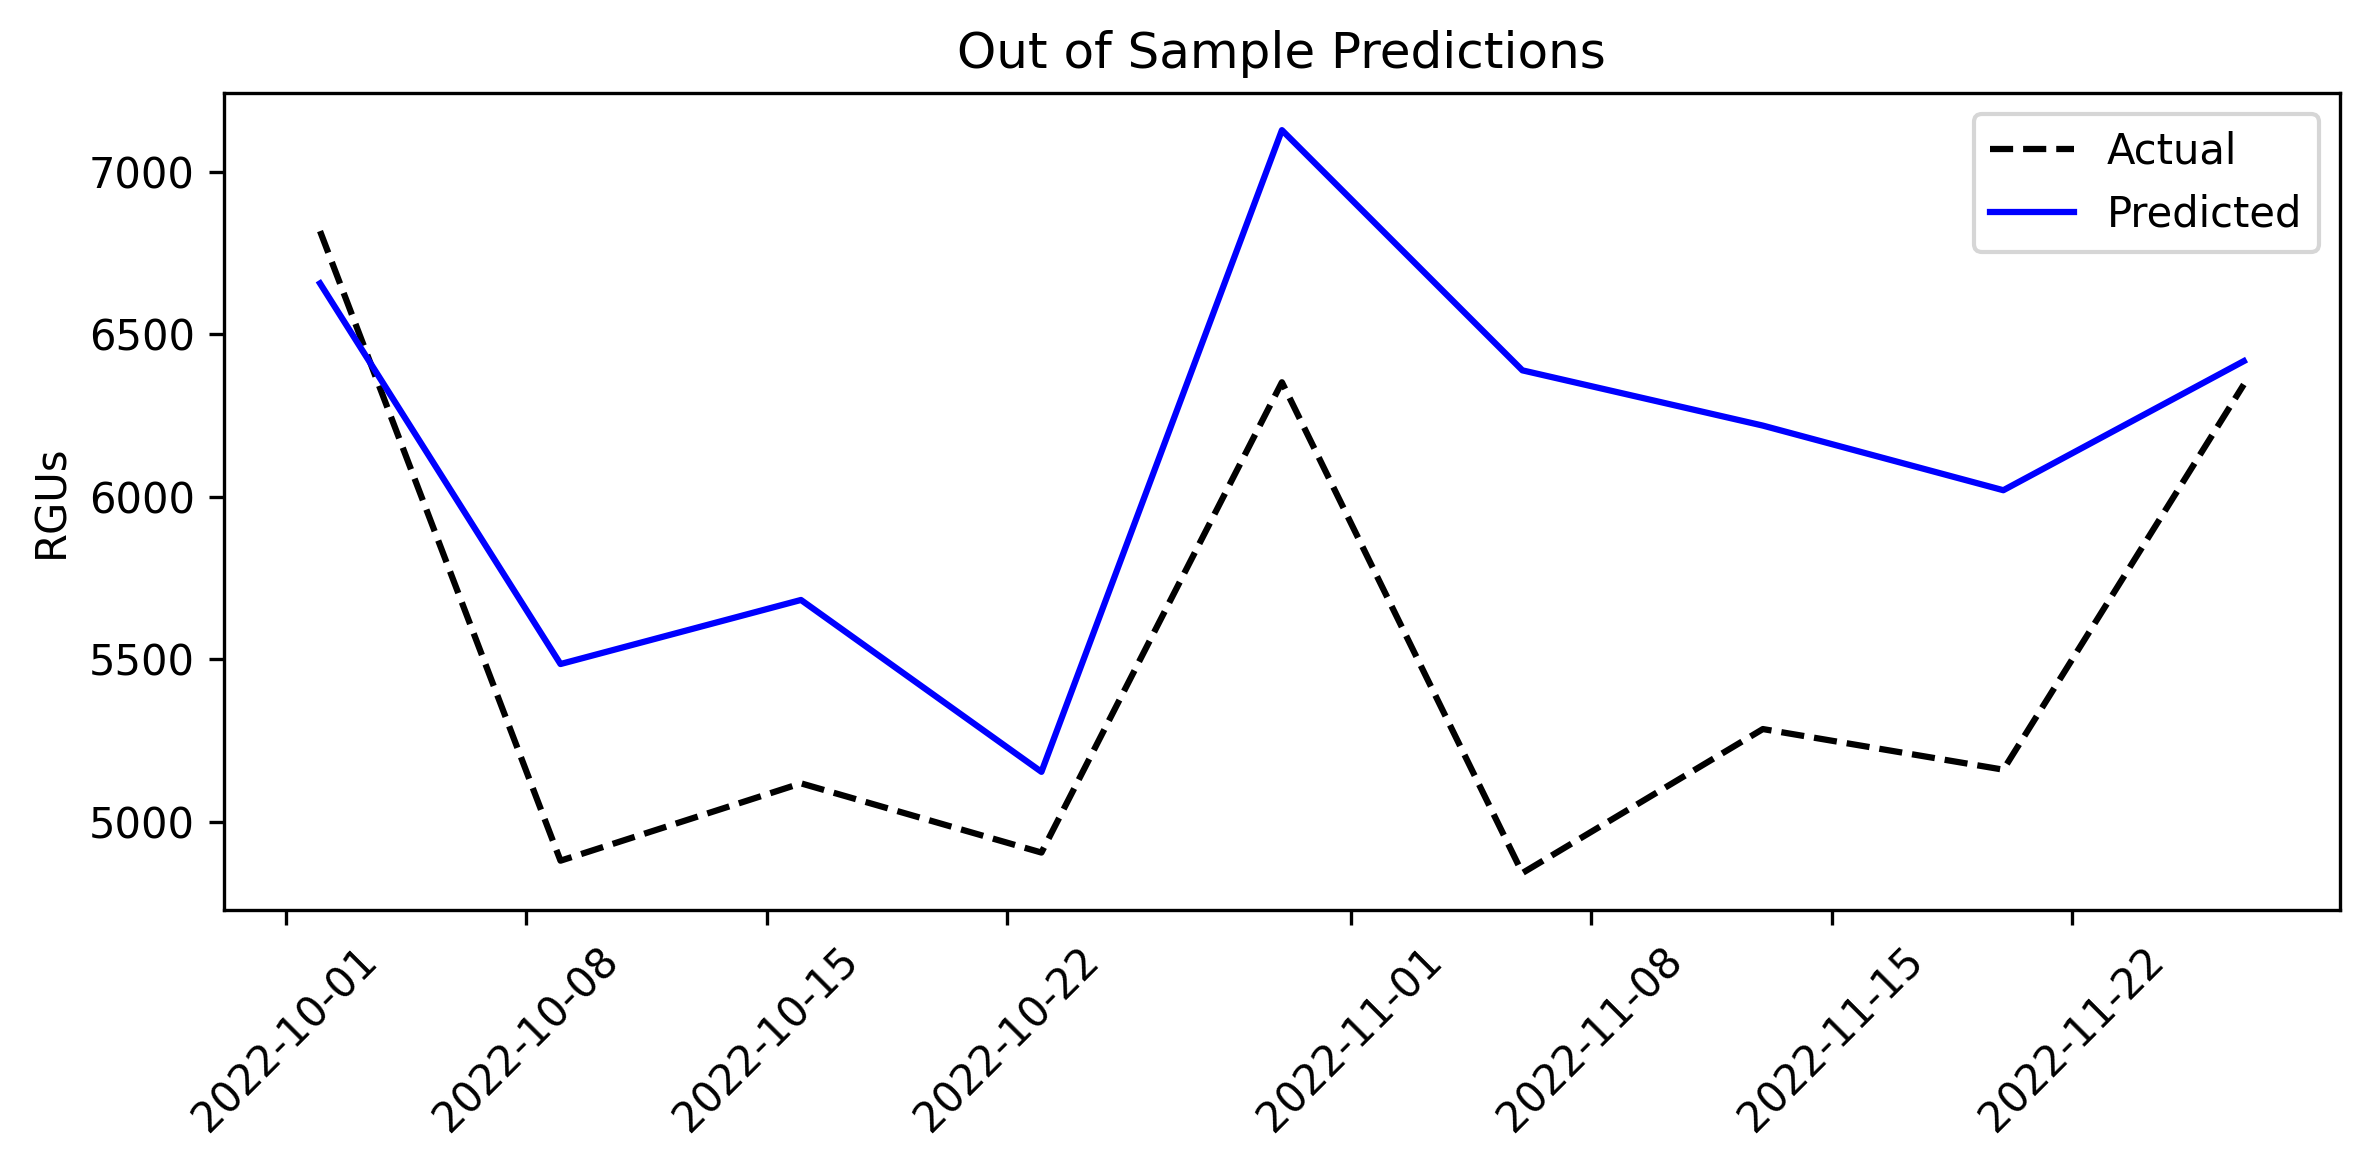

In [209]:
fig = plt.figure(figsize=(8,4),dpi=300)
plt.plot(data_test.Date,y_test_actual,'k--',label = 'Actual')
plt.plot(data_test.Date,y_test_pred,'b-',label = 'Predicted')
plt.ylabel('RGUs')
plt.legend()
plt.title('Out of Sample Predictions')
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('test_fit.png')
plt.show()

# Saturation Curves

In [210]:
def full_extent(ax, pad=0.0):
    """Get the full extent of an axes, including axes labels, tick labels, and
    titles."""
    # For text objects, we need to draw the figure first, otherwise the extents
    # are undefined.
    ax.figure.canvas.draw()
    items = ax.get_xticklabels() + ax.get_yticklabels() 
#    items += [ax, ax.title, ax.xaxis.label, ax.yaxis.label]
    items += [ax, ax.title]
    bbox = Bbox.union([item.get_window_extent() for item in items])

    return bbox.expanded(1.0 + pad, 1.0 + pad)

In [223]:
def plot_contribution_curves(trace) -> plt.Figure:
    channel_contributions = compute_channel_contribution_original_scale(trace).mean(
            ["chain", "draw"]
        )
    
    channel_names = trace.posterior.coords['channel'].values
    
    fig, axes = plt.subplots(
            nrows=len(channel_names),
            ncols=1,
            sharex=False,
            sharey=False,
            figsize=(12, 4 * len(channel_names)),
            layout="constrained",
        )

    for i, channel in enumerate(channel_names[2:]):
        ax = axes[i]
        
        spend_col = [x for x in hsia_spends.columns if channel.replace('IMPRESSIONS','') in x]
        
        sns.regplot(
            x=hsia_spends[spend_col][:91].to_numpy().flatten(),
            y=channel_contributions.sel(channel=channel),
                color=f"C{i}",
                order=2,
                ci=None,
                line_kws={
                    "linestyle": "--",
                    "alpha": 0.5,
                    "label": channel.replace('_IMPRESSIONS',''),
                },
                ax=ax,
            )
        ax.legend(loc="upper right")
        ax.set(title=f"{spend_col}", xlabel=" Weekly Spend", ylabel="Contribution to HSIA RGUs")
        
        extent = full_extent(ax).transformed(fig.dpi_scale_trans.inverted())
        fig.savefig(f'{channel}_dr_curves.png',bbox_inches=extent)
    
    fig.suptitle("Diminishing Returns", fontsize=16)

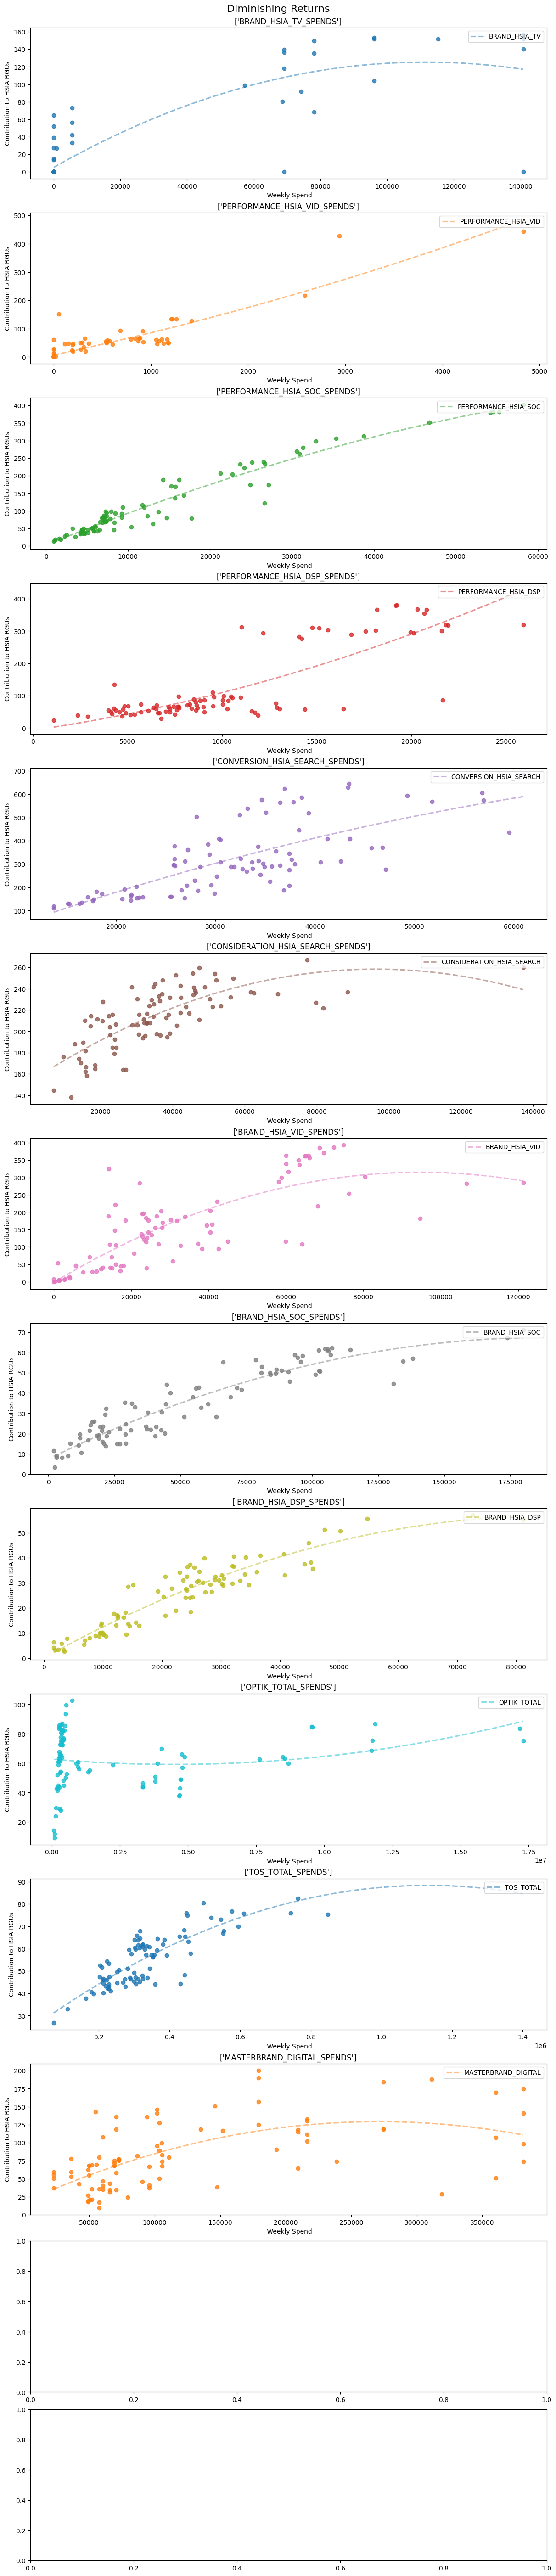

In [224]:
plot_contribution_curves(trace)